# Provider Level Data

**Summary:**

Handle missing data and highly cardinal features through feature engineering in order to aggregate data to the provider level for use in modeling. 

# Contents

[Import Data](#Import-Data)

- Import inpatient, outpatient, beneficiary, and provider labels data
- Create _raw dataframes from original training data for reference
- Add fraud status from provider labels to claims dataframes for EDA

[Data Imputation](#Data-Imputation)

[Feature Engineering](#Feature-Engineering)

*Create a series of helper functions to create new features*

- [Aggregate Claims by Provider](#Aggregate-Claims-by-Provider)


[Extra](#Extra)
- Missingness in provider dataframe
- [Imabalanced Data](#Imabalanced-Data)
- [Fraud stats for provider df](#Fraud-stats-for-provider-df)
  - Fraud stats for provider level data, comparing differences between fraud and non-fraud classes
- Beginning to look at consequence of imputing NaNs with 0s

In [6]:
# import libraries
import matplotlib.pyplot as plt
import missingno as msno

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, average_precision_score, roc_curve
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import precision_recall_curve

# Import Data

Import data and create _raw copy for reference, just in case. 

In [9]:
# beneficiary data
beneficiary = pd.read_csv('data/archive/Train_Beneficiarydata-1542865627584.csv')
beneficiary_raw = beneficiary.copy()
print(beneficiary.shape)
beneficiary.head(2)

(138556, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50


In [11]:
# inpatient data
inpatient = pd.read_csv('data/archive/Train_Inpatientdata-1542865627584.csv')
inpatient_raw = inpatient.copy()
print(inpatient.shape)
inpatient.head(2)

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN


In [13]:
# outpatient data
outpatient = pd.read_csv('data/archive/Train_Outpatientdata-1542865627584.csv')
outpatient_raw = outpatient.copy()
print(outpatient.shape)
outpatient.head(2)

(517737, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380


In [15]:
# provider label data
labels = pd.read_csv('data/archive/Train-1542865627584.csv')
print(labels.shape)
labels.head(2)

(5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes


In [17]:
# create list of providers suspected of fraud
fraud_providers = labels[labels['PotentialFraud']=='Yes']
fraud_providers = fraud_providers['Provider'].to_list()
fraud_providers

['PRV51003',
 'PRV51005',
 'PRV51021',
 'PRV51037',
 'PRV51052',
 'PRV51059',
 'PRV51064',
 'PRV51067',
 'PRV51077',
 'PRV51084',
 'PRV51103',
 'PRV51119',
 'PRV51126',
 'PRV51145',
 'PRV51146',
 'PRV51148',
 'PRV51149',
 'PRV51159',
 'PRV51170',
 'PRV51173',
 'PRV51178',
 'PRV51242',
 'PRV51244',
 'PRV51249',
 'PRV51263',
 'PRV51337',
 'PRV51338',
 'PRV51347',
 'PRV51357',
 'PRV51369',
 'PRV51378',
 'PRV51390',
 'PRV51393',
 'PRV51399',
 'PRV51401',
 'PRV51410',
 'PRV51421',
 'PRV51426',
 'PRV51433',
 'PRV51434',
 'PRV51447',
 'PRV51459',
 'PRV51471',
 'PRV51480',
 'PRV51482',
 'PRV51490',
 'PRV51495',
 'PRV51501',
 'PRV51507',
 'PRV51539',
 'PRV51542',
 'PRV51560',
 'PRV51567',
 'PRV51574',
 'PRV51578',
 'PRV51584',
 'PRV51586',
 'PRV51590',
 'PRV51593',
 'PRV51604',
 'PRV51614',
 'PRV51805',
 'PRV51818',
 'PRV51826',
 'PRV51836',
 'PRV51840',
 'PRV51842',
 'PRV51851',
 'PRV51857',
 'PRV51868',
 'PRV51873',
 'PRV51876',
 'PRV51920',
 'PRV51940',
 'PRV51948',
 'PRV51951',
 'PRV51979',

# Data Imputation

[Contents](#Contents)

### Initial imputation strategy:

**Inpatient DeductibleAmountPaid** Assuming a missing value indicates deductible has not been paid, impute 899 values with 0

**Outpatient ClmAdmitDiagnosisCode** From data dictionary: "...primarily used in inpatient claims and may not always be populated in outpatient datasets." Impute 412312 outpatient values with '0'.

**PhysicianIDs** and **Codes** with missing values will not matter for modeling, as they will be aggregated into counts.

**Beneficiary DOD** will be dropped

In [19]:
# create transformers
inpatient_transformer = ColumnTransformer([
    ('ip_deductible_impute', SimpleImputer(strategy='constant', fill_value=0), ['DeductibleAmtPaid']),
    # other columns pass through
], remainder='passthrough')

outpatient_transformer = ColumnTransformer([
    ('op_diagnosis_impute', SimpleImputer(strategy='constant', fill_value='0'), ['ClmAdmitDiagnosisCode']),
], remainder='passthrough')

In [21]:
inpatient.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN


In [23]:
# apply transformer to inpatient data
print("Processing Inpatient Data...")
print(f"Before - DeductibleAmtPaid nulls: {inpatient['DeductibleAmtPaid'].isna().sum()}")

inpatient_transformed = inpatient_transformer.fit_transform(inpatient)

# Convert back to DataFrame (ColumnTransformer returns arrays)
inpatient_clean = pd.DataFrame(
    inpatient_transformed,
    columns=['DeductibleAmtPaid'] + [col for col in inpatient.columns if col != 'DeductibleAmtPaid'],
    index=inpatient.index
)

print(f"After - DeductibleAmtPaid nulls: {inpatient_clean['DeductibleAmtPaid'].isna().sum()}")
print(f"Values imputed with 0: {(inpatient_clean['DeductibleAmtPaid'] == 0).sum()}\n")

Processing Inpatient Data...
Before - DeductibleAmtPaid nulls: 899
After - DeductibleAmtPaid nulls: 0
Values imputed with 0: 899



In [25]:
inpatient_clean['DeductibleAmtPaid'].isnull().sum()

0

In [27]:
# check datatypes
inpatient_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DeductibleAmtPaid       40474 non-null  object
 1   BeneID                  40474 non-null  object
 2   ClaimID                 40474 non-null  object
 3   ClaimStartDt            40474 non-null  object
 4   ClaimEndDt              40474 non-null  object
 5   Provider                40474 non-null  object
 6   InscClaimAmtReimbursed  40474 non-null  object
 7   AttendingPhysician      40362 non-null  object
 8   OperatingPhysician      23830 non-null  object
 9   OtherPhysician          4690 non-null   object
 10  AdmissionDt             40474 non-null  object
 11  ClmAdmitDiagnosisCode   40474 non-null  object
 12  DischargeDt             40474 non-null  object
 13  DiagnosisGroupCode      40474 non-null  object
 14  ClmDiagnosisCode_1      40474 non-null  object
 15  Cl

**Question:** applying the transformer messed with datatypes. Is there a better way to handle this, rather than cleaning them up manually (below)? 

In [31]:
# explicitly convert numerical features to float type
inpatient_clean['InscClaimAmtReimbursed'] = inpatient_clean['InscClaimAmtReimbursed'].astype(float)
inpatient_clean['DeductibleAmtPaid'] = inpatient_clean['DeductibleAmtPaid'].astype(float)

In [33]:
inpatient_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DeductibleAmtPaid       40474 non-null  float64
 1   BeneID                  40474 non-null  object 
 2   ClaimID                 40474 non-null  object 
 3   ClaimStartDt            40474 non-null  object 
 4   ClaimEndDt              40474 non-null  object 
 5   Provider                40474 non-null  object 
 6   InscClaimAmtReimbursed  40474 non-null  float64
 7   AttendingPhysician      40362 non-null  object 
 8   OperatingPhysician      23830 non-null  object 
 9   OtherPhysician          4690 non-null   object 
 10  AdmissionDt             40474 non-null  object 
 11  ClmAdmitDiagnosisCode   40474 non-null  object 
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [39]:
# apply to outpatient data
print("Processing Outpatient Data...")
print(f"Before - ClmAdmitDiagnosisCode nulls: {outpatient['ClmAdmitDiagnosisCode'].isna().sum()}")

outpatient_transformed = outpatient_transformer.fit_transform(outpatient)

# Convert back to DataFrame
outpatient_clean = pd.DataFrame(
    outpatient_transformed,
    columns=['ClmAdmitDiagnosisCode'] + [col for col in outpatient.columns if col != 'ClmAdmitDiagnosisCode'],
    index=outpatient.index
)

print(f"After - ClmAdmitDiagnosisCode nulls: {outpatient_clean['ClmAdmitDiagnosisCode'].isna().sum()}")
print(f"Values imputed with '0': {(outpatient_clean['ClmAdmitDiagnosisCode'] == '0').sum()}\n")

Processing Outpatient Data...
Before - ClmAdmitDiagnosisCode nulls: 412312
After - ClmAdmitDiagnosisCode nulls: 0
Values imputed with '0': 412312



In [40]:
outpatient_clean['ClmAdmitDiagnosisCode'].isnull().sum()

0

In [43]:
# explicitly convert numerical features to float type
outpatient_clean['InscClaimAmtReimbursed'] = outpatient_clean['InscClaimAmtReimbursed'].astype(float)
outpatient_clean['DeductibleAmtPaid'] = outpatient_clean['DeductibleAmtPaid'].astype(float)

In [45]:
outpatient_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ClmAdmitDiagnosisCode   517737 non-null  object 
 1   BeneID                  517737 non-null  object 
 2   ClaimID                 517737 non-null  object 
 3   ClaimStartDt            517737 non-null  object 
 4   ClaimEndDt              517737 non-null  object 
 5   Provider                517737 non-null  object 
 6   InscClaimAmtReimbursed  517737 non-null  float64
 7   AttendingPhysician      516341 non-null  object 
 8   OperatingPhysician      90617 non-null   object 
 9   OtherPhysician          195046 non-null  object 
 10  ClmDiagnosisCode_1      507284 non-null  object 
 11  ClmDiagnosisCode_2      322357 non-null  object 
 12  ClmDiagnosisCode_3      203257 non-null  object 
 13  ClmDiagnosisCode_4      125596 non-null  object 
 14  ClmDiagnosisCode_5  

In [49]:
# to maintain consistent naming
beneficiary_clean = beneficiary.copy()

### Visualize missingness in dataframes after imputation

<Axes: >

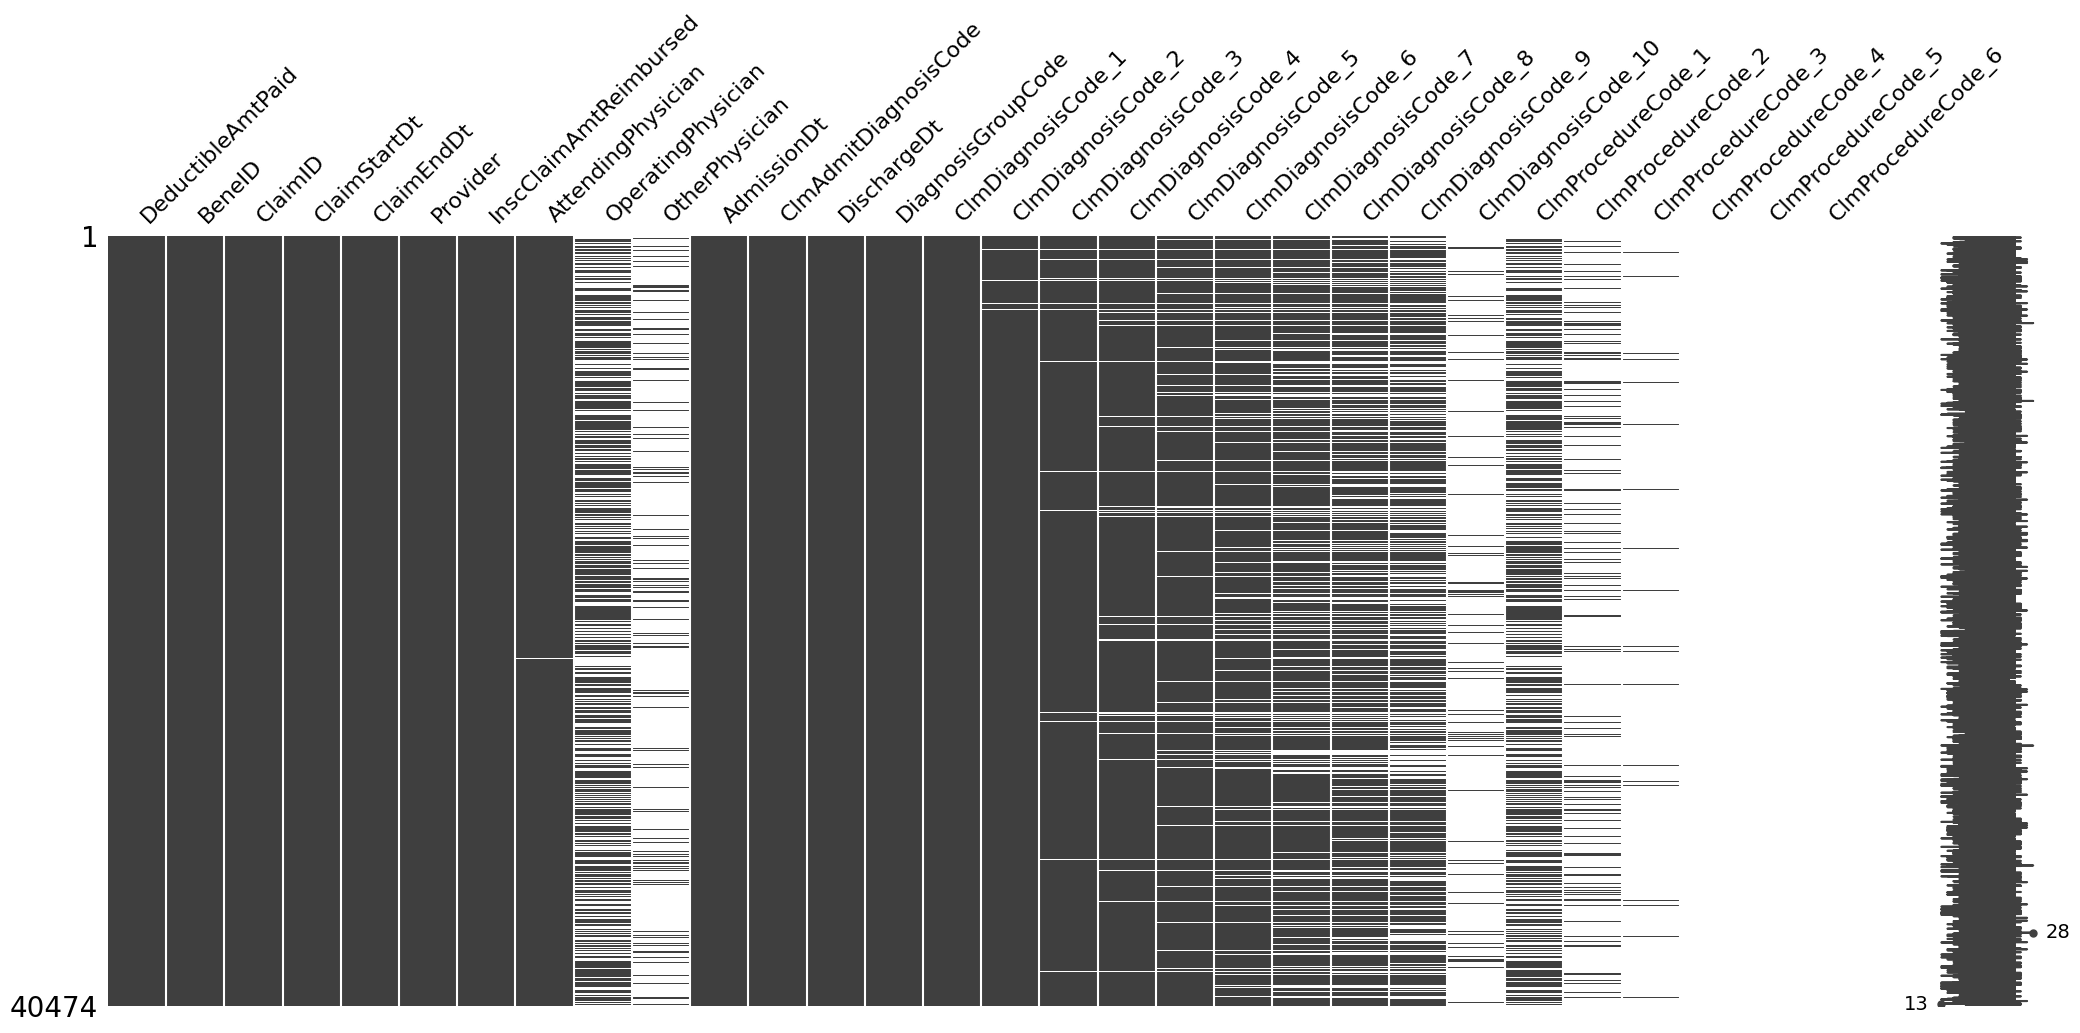

In [53]:
msno.matrix(inpatient_clean)

<Axes: >

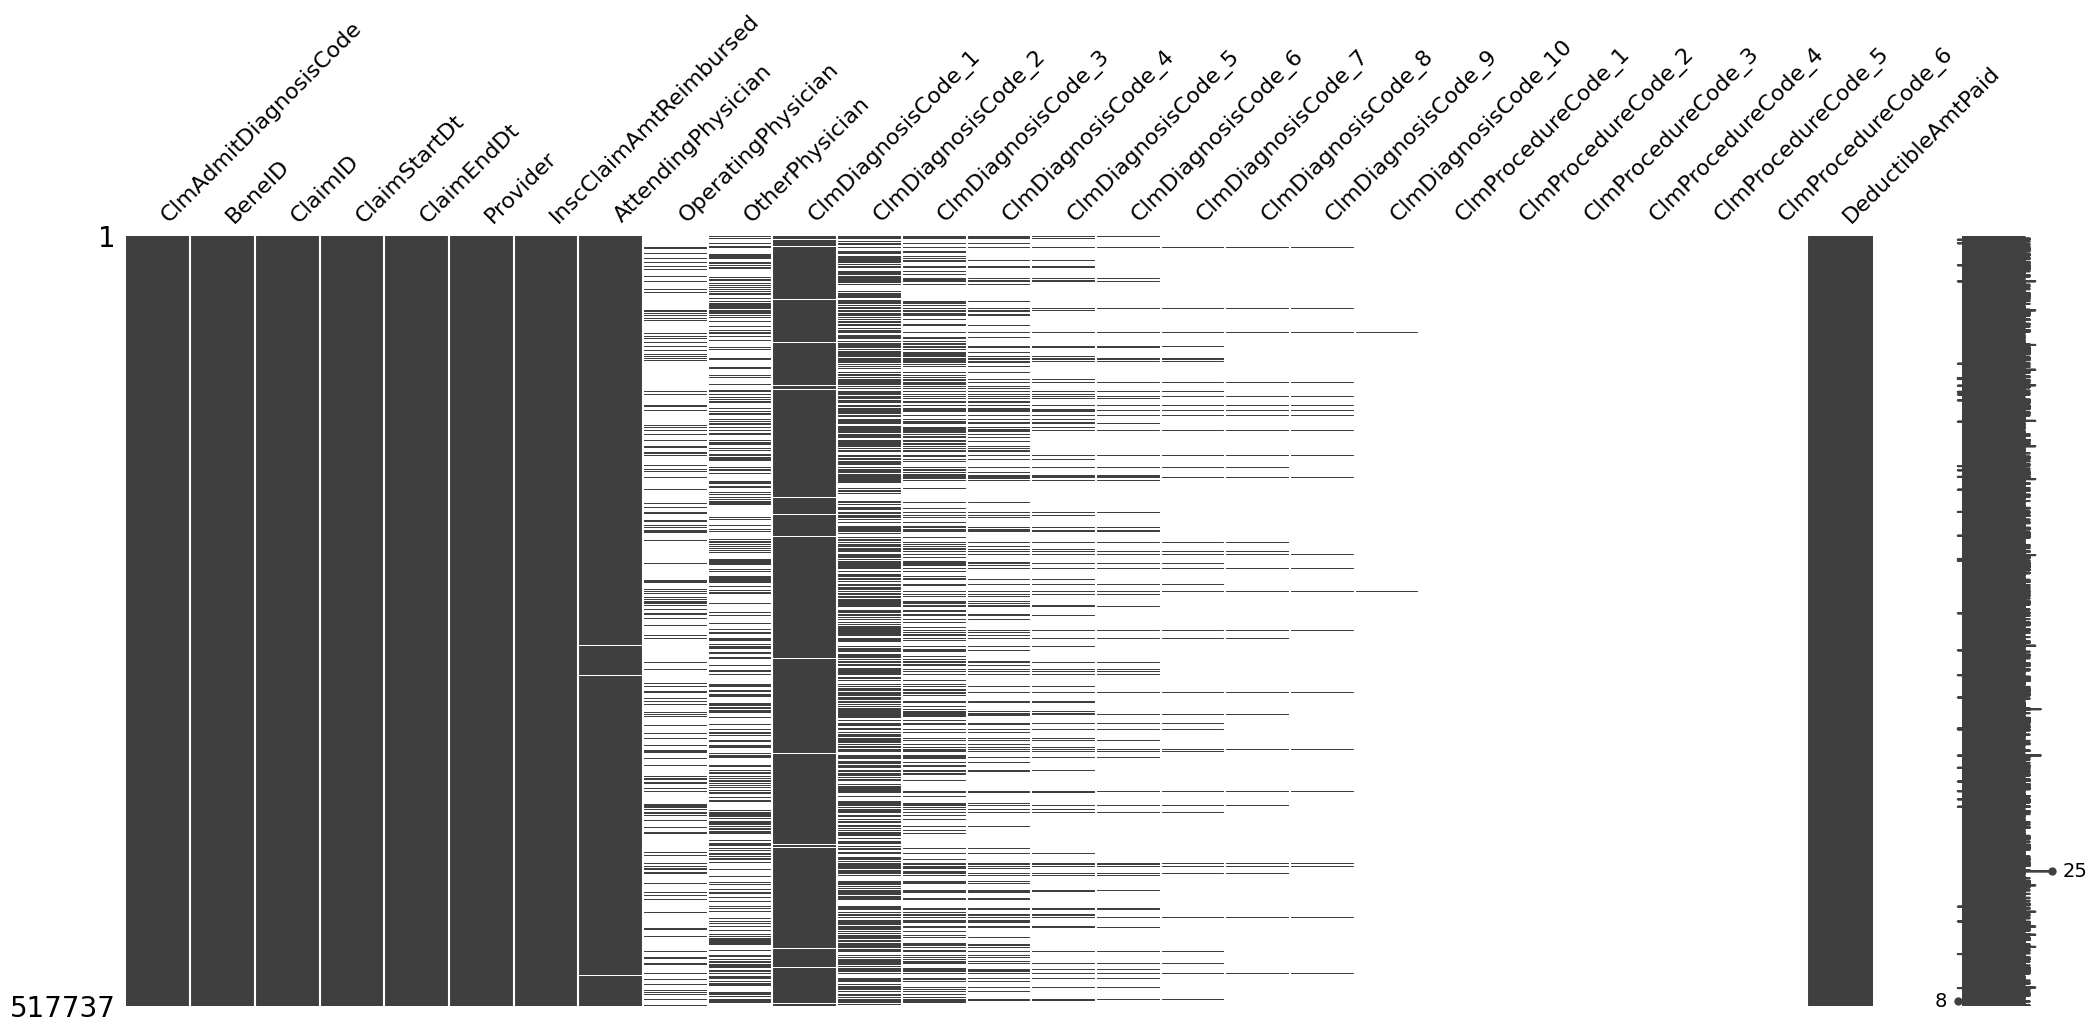

In [55]:
msno.matrix(outpatient_clean)

**Note:** Missing IP/OP data for PhysicianIDs and Clm Codes will be handled through aggregation

<Axes: >

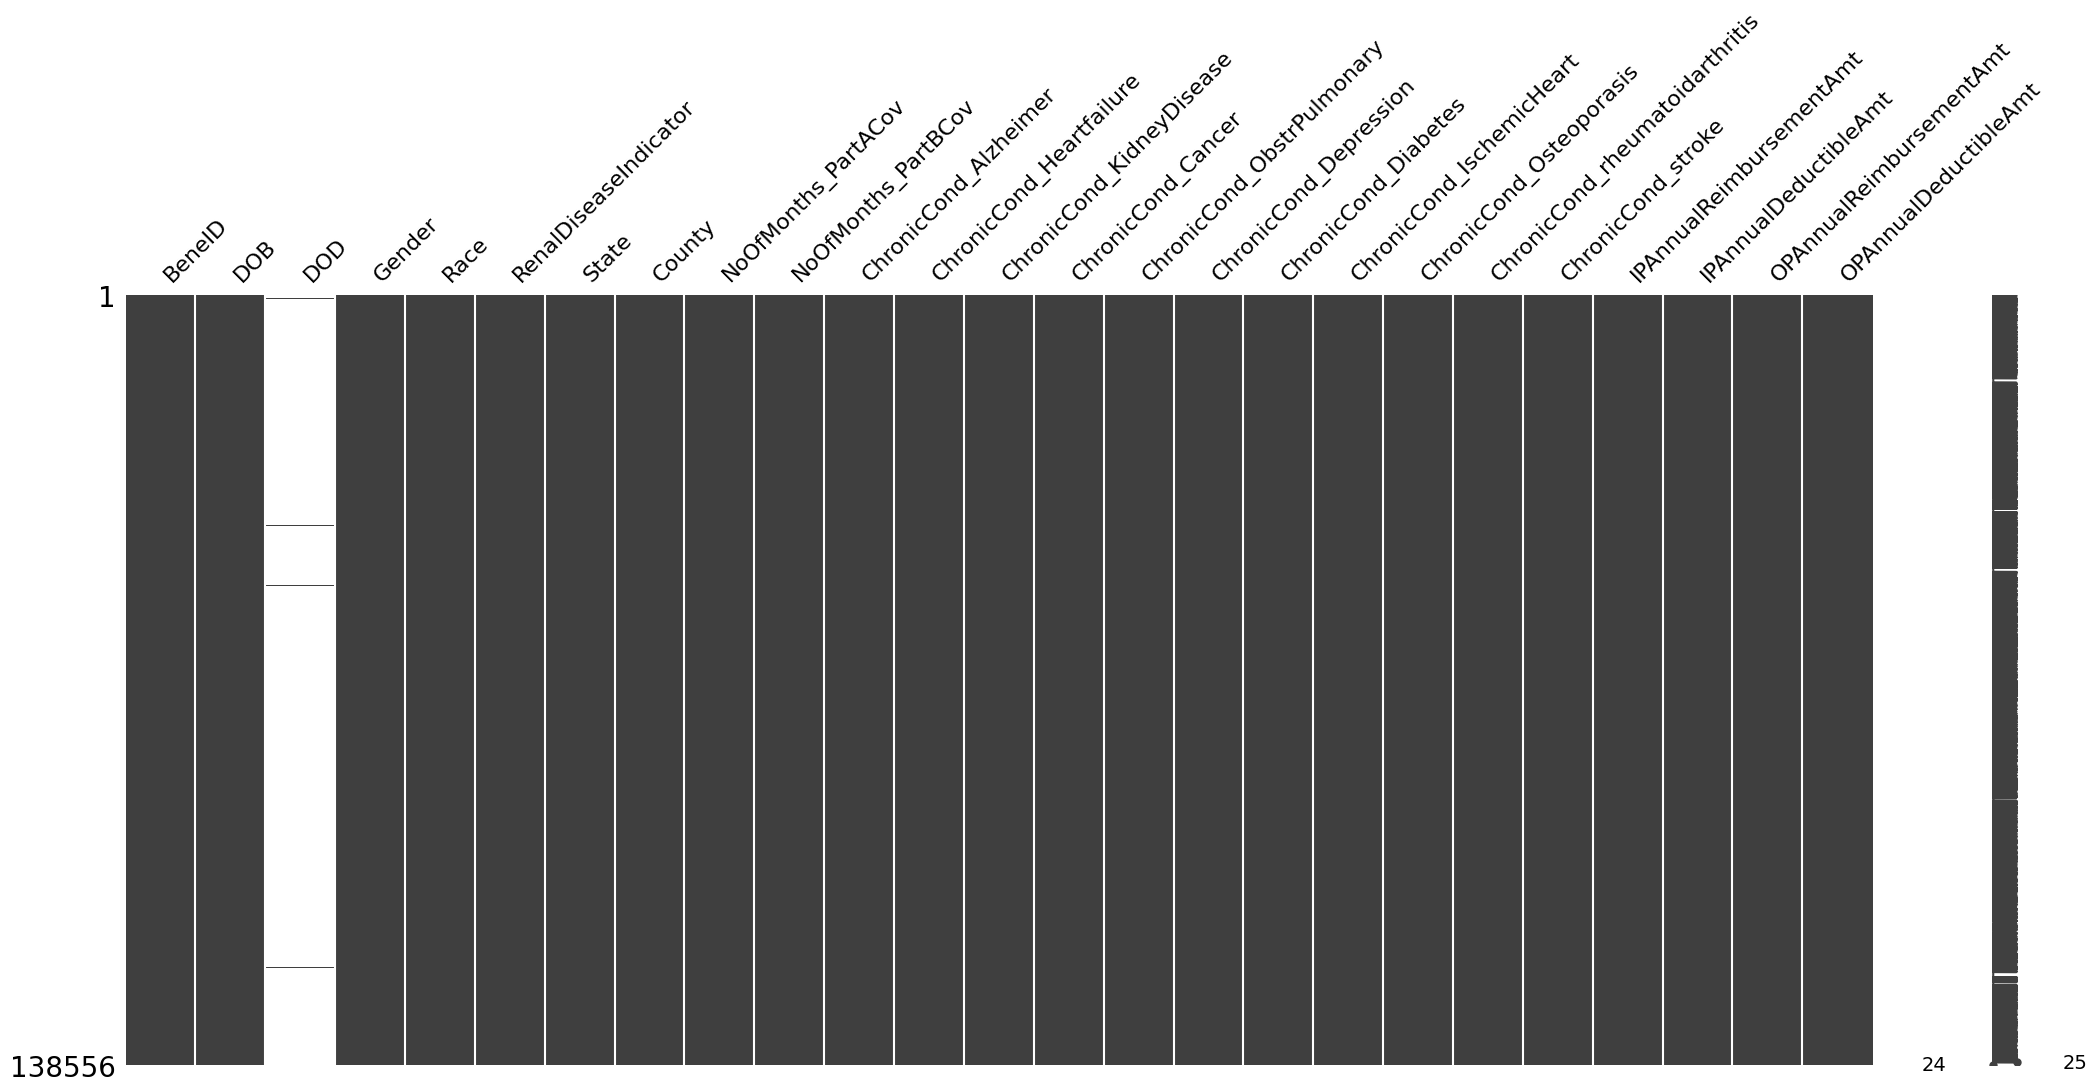

In [57]:
msno.matrix(beneficiary_clean)

**Note:** DOD will be dropped 

# Feature Engineering
- Bin high cardinality features (and handle missing values)
- Create interesting features for analysis

  
Apply feature engineering to **imputed dataframes** from above:

**No longer using inpatient, outpatient, and beneficiary**
- inpatient_clean
- outpatient_clean
- beneficiary_clean

[Contents](#Contents)

### Patient ages

- Use beneficiary DOB to add an age-at-time-of-service column in cleaned inpatient/outpatient datasets.
- This will be aggregated at the provider level to mean_patient_age
- Drop DOB

**At provider level, calculate:**
- mean patient age at time of service per provider

      ClaimStartDt - DOB

In [74]:
def add_patient_ages(claims_df, beneficiary_df):
    """
    Add patient age (in years) at time of service to claims dataframes.
    This is at the claim level
    
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Claims dataframe (inpatient or outpatient)
    beneficiary_df : pd.DataFrame
        Beneficiary dataframe
    
    Returns:
    --------
    pd.DataFrame
        Claims dataframe with 'mean_patient_age' column added
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()
    
    # Merge DOB to claims data for calculating age
    df = df.merge(beneficiary_df[['BeneID', 'DOB']], 
                  on='BeneID', 
                  how='left')
    
    # Convert to datetime if not already
    df['DOB'] = pd.to_datetime(df['DOB'])
    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
    
    # Calculate age at time of service
    df['age'] = ((df['ClaimStartDt'] - df['DOB']).dt.days / 365.25).astype(int)

    # Drop DOB from claims data
    df.drop(columns=['DOB'], inplace=True)
    
    return df

In [76]:
# add column to ip/op dataframes
inpatient_clean = add_patient_ages(inpatient_clean, beneficiary_clean)
outpatient_clean = add_patient_ages(outpatient_clean, beneficiary_clean)

In [77]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,age
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,66
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,94
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,70704,2869,4148,9904.0,NaN,NaN,NaN,NaN,NaN,52
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,4254,5990,NaN,8605.0,NaN,NaN,NaN,NaN,NaN,56
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,71590,V4502,NaN,9390.0,NaN,NaN,NaN,NaN,NaN,90
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,0414,41400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90


## Beneficiary data

Understanding beneficiary data and how to analyze for provider fraud.

Example: 2 providers, A (non-fraud) and B (fraud)

Provider A (non-fraud):
- 10 patients with these annual costs:
    2,300 | 2,400 | 2,450 | 2,500 | 2,500 | 2,500 | 2,550 | 2,600 | 2,650 | 2,550
- Mean: 2,500
- Standard Deviation: ~110
- Pattern: Everyone clusters tightly around 2,500

Provider B (fraud):
- 10 patients with these annual costs:
    1,000 | 1,000 | 1,000 | 1,000 | 1,000 | 1,000 | 1,000 | 1,000 | 8,500 | 8,500
- Mean: 2,500 (same as Provider A)
- Standard Deviation: ~3,354
- Pattern: 8 low-cost patients + 2 extremely high-cost patients

Both have same average claim amount and annual beneficiary cost
- Provider A: All patients cost about the same (normal healthcare variation)
- Provider B: Most patients barely use services, but 2 patients have suspiciously high costs (fraud scheme using real patients as cover + fake/inflated claims on a few)



**ip to op cost ratio**: Can be fraud indicator (but not always) 
- legitimate high ratio: provider specializes in conditions requiring hopsitalization
- suspicious high ratio: provider is unnecessarily over-admitting patients for inpatient care

balanced ratio more likely for general practice providers or multi-specialty providers.

**At provider level, calculate:**
- mean, std, max IPAnnualReimbursementAmt
- mean, std, max OPAnnualReimbursementAmt
- mean, std, max ip_total
- mean, std, max op_total
- mean, std, max total_annual
- ip_to_op ratio

### Beneficiary totals

Calculate the total ip/op reimbursement and deductible amounts for each beneficiary, as well as a total inpatient and outpatient amount.

    inpatient total = IP Reimbursement + IP Deductible
    outpatient total =  IP Reimbursemnt + IP Deductible
    total beneficiary annual = inpatient total + outpatient total

In [84]:
def add_bene_totals(beneficiary_df):
    """
    Create inpatient, outpatient, and (inpatient + outpatient) reimbursement and deductible totals
    
    Parameters:
    -----------
        beneficiary_df : pd.DataFrame
            Beneficiary dataframe
        
    Returns:
    --------
        pd.DataFrame
            dataframe with 'ip_bene_total', 'op_bene_total', and 'total_bene_annual' columns
    """
   
    bene_df = beneficiary_df.copy()
    
    # Calculate total costs
    bene_df['ip_bene_total'] = bene_df['IPAnnualReimbursementAmt'] + bene_df['IPAnnualDeductibleAmt']
    bene_df['op_bene_total'] = bene_df['OPAnnualReimbursementAmt'] + bene_df['OPAnnualDeductibleAmt']
    bene_df['total_bene_annual'] = bene_df['ip_bene_total'] + bene_df['op_bene_total']

    return bene_df

In [86]:
beneficiary_clean.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50


In [88]:
add_bene_totals(beneficiary_clean)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ip_bene_total,op_bene_total,total_bene_annual
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,2,1,1,36000,3204,60,70,39204,130,39334
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,0,0,30,50,0,80,80
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,2,0,0,90,40,0,130,130
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,1,1,2,0,0,1810,760,0,2570,2570
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,2,2,0,0,1790,1200,0,2990,2990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,1939-07-01,NaN,1,1,0,39,140,12,12,...,2,2,2,0,0,430,460,0,890,890
138552,BENE159195,1938-12-01,NaN,2,1,0,49,530,12,12,...,2,2,2,0,0,880,100,0,980,980
138553,BENE159196,1916-06-01,NaN,2,1,0,6,150,12,12,...,2,2,2,2000,1068,3240,1390,3068,4630,7698
138554,BENE159197,1930-01-01,NaN,1,1,0,16,560,12,12,...,2,2,2,0,0,2650,10,0,2660,2660


### Full or partial coverage

Add full or partial coverage flag to data

    full coverage = 'Yes': 12 months coverage
    full coverage = 'No': < 12 months coverage

In [97]:
def add_coverage_indicator(beneficiary_df):
    """
    Add beneficiary columns that identify whether a patient has full or partial ip/op coverage.
    
    NoOfMonths_PartACov is the number of months patient had coverage for inpatient care.
    NoOfMonths_PartBCov is the number of months patient had coverage for outpatient care.
    
    Parameters:
    -----------
    beneficiary_df : pd.DataFrame
        Beneficiary dataframe
    
    Returns:
    --------
    pd.DataFrame
        beneficiary dataframe with 'full_ip_coverage' and 'full_op_coverage' columns added
    """
    # Create a copy to avoid modifying original
    df = beneficiary_df.copy()
    
    # create column identifying full or partial inpatient coverage 
    df['full_ip_coverage'] = np.where(df['NoOfMonths_PartACov'] == 12, 'Yes', 'No')
    
    # create column identifying full or partial outpatient coverage 
    df['full_op_coverage'] = np.where(df['NoOfMonths_PartBCov'] == 12, 'Yes', 'No')
    
    return df

In [99]:
# create coverage flag
beneficiary_clean = add_coverage_indicator(beneficiary_clean)

In [101]:
beneficiary_clean.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,full_ip_coverage,full_op_coverage
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,2,1,1,36000,3204,60,70,Yes,Yes
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,0,0,30,50,Yes,Yes


In [103]:
beneficiary_clean['full_ip_coverage'].value_counts()

full_ip_coverage
Yes    137389
No       1167
Name: count, dtype: int64

### Number of chronic conditions

Count the number of chronic conditions for each beneficiary

Based on EDA, assuming:
- 1 = has chronic condition
- 2 = does not have chronic condition

At provider level, will use this to calculate the mean number of patient chronic conditions and variance from the mean (std).

**Visualize conditions:**

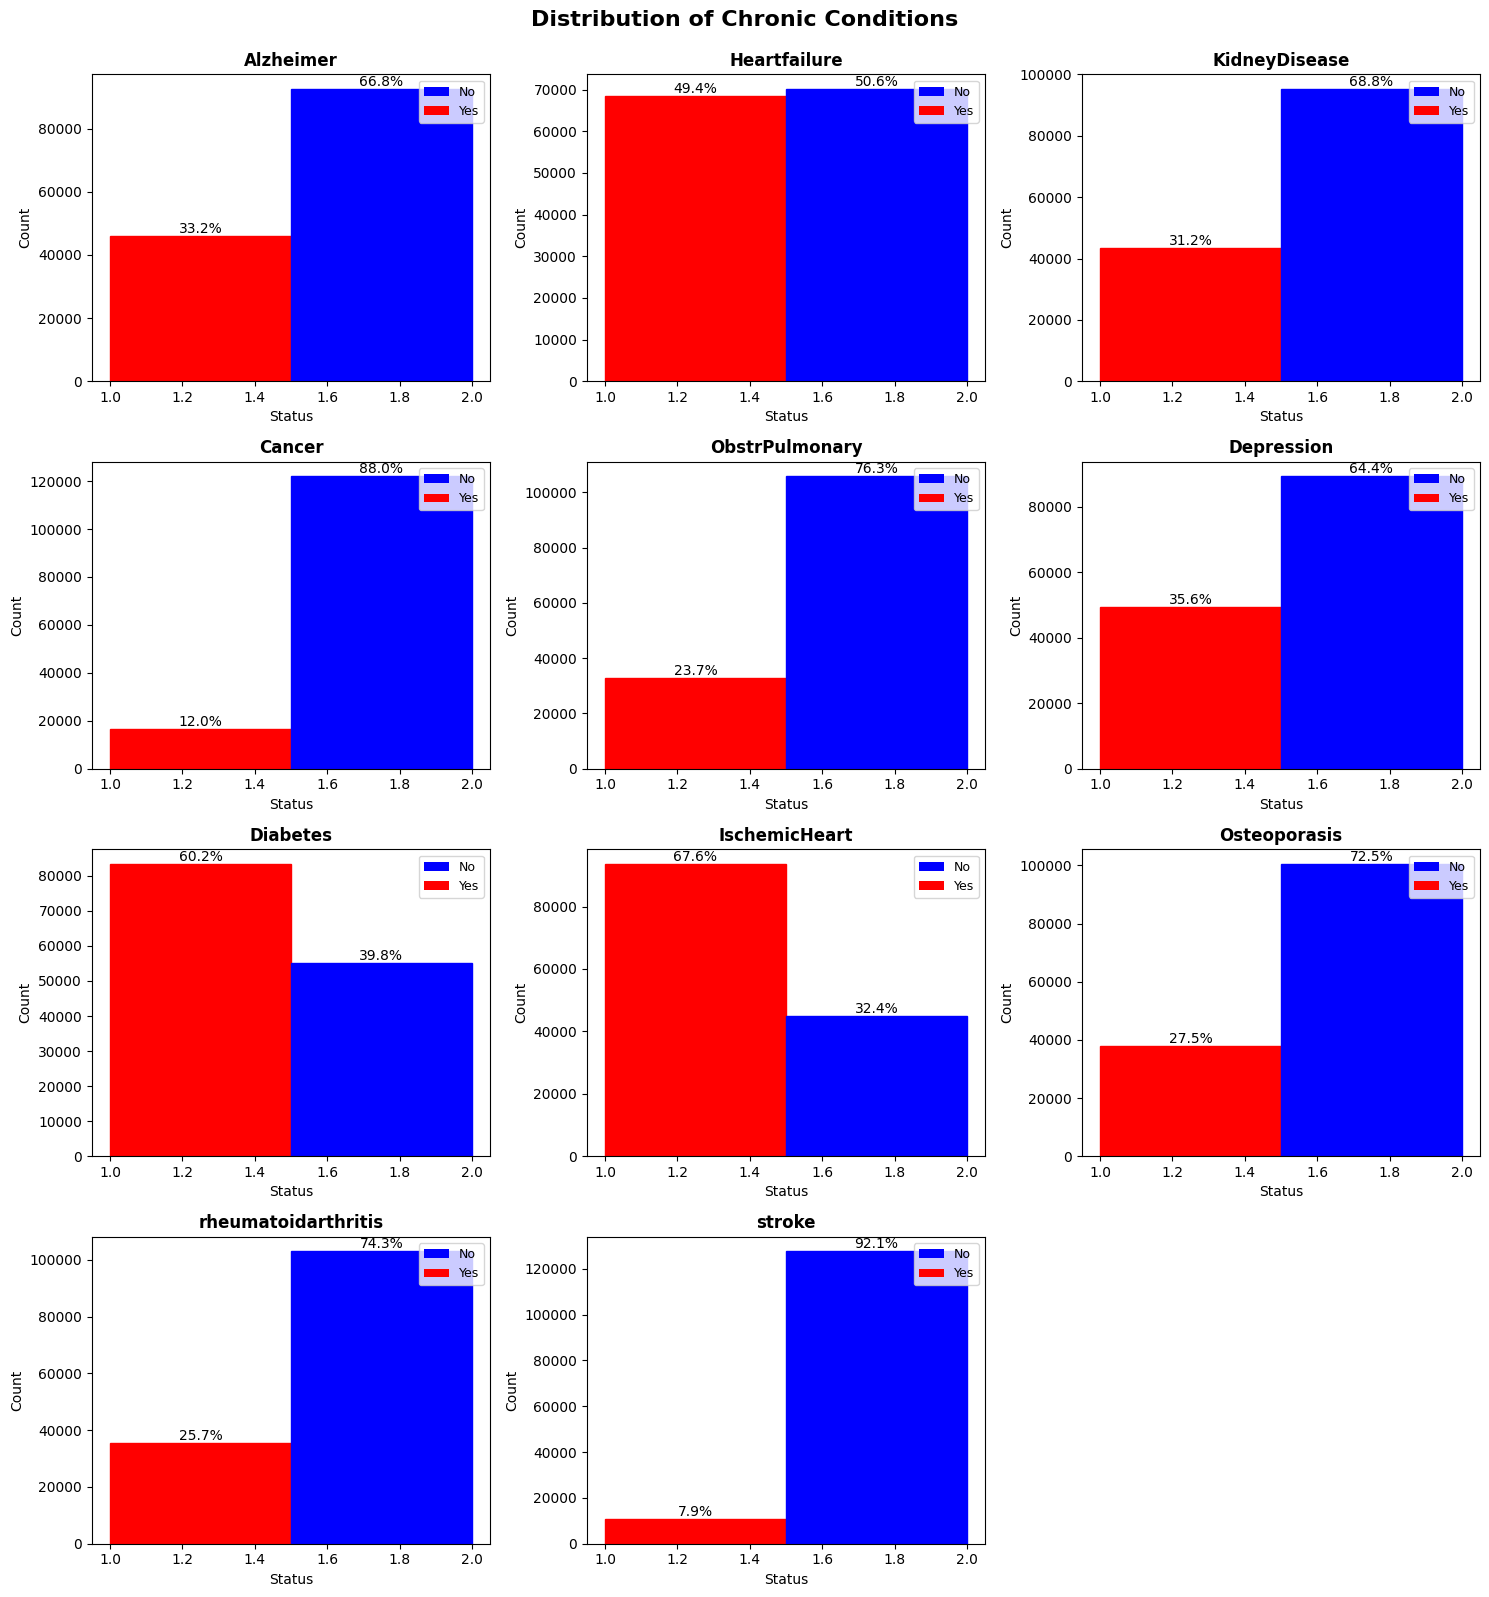

In [109]:
# List of conditions
conditions = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
              'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
              'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
              'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
              'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
              'ChronicCond_stroke']

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.flatten()

status_colors = ['red', 'blue'] 

# Create legend patches
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='No'),
                   Patch(facecolor='red', label='Yes')]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Calculate percentages from data
    percentages = beneficiary[condition].value_counts(normalize=True).sort_index() * 100
    
    # Create histogram
    sns.histplot(beneficiary[condition], ax=ax, bins=2, color='gray')
    
    # Color code the bars based on status
    for i, bar in enumerate(ax.patches):
        bar.set_color(status_colors[i])  
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{percentages.iloc[i]:.1f}%',
               ha='center', va='bottom', fontsize=10)
    
    # Clean title
    title = condition.replace('ChronicCond_', '')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Status')
    ax.set_ylabel('Count')
    
    # Add legend to each subplot
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

axes[11].axis('off')

plt.suptitle('Distribution of Chronic Conditions', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [110]:
beneficiary['ChronicCond_Diabetes'].value_counts()

ChronicCond_Diabetes
1    83391
2    55165
Name: count, dtype: int64

In [112]:
def add_chronic_conditions_counts(beneficiary_df):
    """
    Add column that counts the number of chronic conditions associated with each patient.
    Assuming that if the value of a ChronicCond_ column is = 1, patient has chronic condition.
    Assuming that if the value of a ChronicCond_ column is = 2, patient does not have chronic condition.
    Count the number of 1s appearing across ChronicCond_ features
    
    Parameters:
    -----------
    beneficiary_df : pd.DataFrame
        Beneficiary dataframe
    
    Returns:
    --------
    pd.DataFrame
        beneficiary dataframe with 'number_chronic_conditions' associated with each patient
    """
    # Create a copy to avoid modifying original
    df = beneficiary_df.copy()
    
    # create a list of chronic coniditions 
    chronic_cols = [col for col in df.columns if 'ChronicCond_' in col]
    
    # create column with number of chronic conditions associated with each patient 
    df['number_chronic_conditions'] = (df[chronic_cols] == 1).sum(axis=1)
    
    return df

In [113]:
beneficiary_clean = add_chronic_conditions_counts(beneficiary_clean)

In [114]:
beneficiary_clean

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,2,1,1,36000,3204,60,70,Yes,Yes,7
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,0,0,30,50,Yes,Yes,0
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,2,0,0,90,40,Yes,Yes,2
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,1,1,2,0,0,1810,760,Yes,Yes,6
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,2,2,0,0,1790,1200,Yes,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,1939-07-01,NaN,1,1,0,39,140,12,12,...,2,2,2,0,0,430,460,Yes,Yes,1
138552,BENE159195,1938-12-01,NaN,2,1,0,49,530,12,12,...,2,2,2,0,0,880,100,Yes,Yes,2
138553,BENE159196,1916-06-01,NaN,2,1,0,6,150,12,12,...,2,2,2,2000,1068,3240,1390,Yes,Yes,6
138554,BENE159197,1930-01-01,NaN,1,1,0,16,560,12,12,...,2,2,2,0,0,2650,10,Yes,Yes,3


### Inpatient duration (length of hospitalization)

Create an inpatient duration column

    Discharge date - Admission date

In [125]:
def add_inpatient_duration(inpatient_df):
    """
    Add column that indicates duration (in days) of admission stay (hospitalization). 
    Only relevant for inpatient data.
    
    Parameters:
    -----------
    inpatient_df : pd.DataFrame
        Inpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        inpatient dataframe with 'inpatient_duration' column
    """
    # Create a copy to avoid modifying original
    df = inpatient_df.copy()

    # convert admission and discharge dates to datetime objects
    df['AdmissionDt'] = pd.to_datetime(df['AdmissionDt'])
    df['DischargeDt'] = pd.to_datetime(df['DischargeDt'])
    
    # create column with admission duration 
    df['inpatient_duration'] = (df['DischargeDt'] - df['AdmissionDt']).dt.days
    
    return df

In [127]:
inpatient_clean = add_inpatient_duration(inpatient_clean)

In [129]:
inpatient_clean.head()

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,age,inpatient_duration
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,6
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,66,2
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,3
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,94,8
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,71,17


### Claim duration

Create a claim duration column

    claim end date - claim start date

In [135]:
def add_claim_duration(claim_df):
    """
    Add column that indicates claim duration. 
    
    Parameters:
    -----------
    claim_df : pd.DataFrame
        Inpatient or Outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claim dataframe with 'claim_duration' column
    """
    
    # Create a copy to avoid modifying original
    df = claim_df.copy()

    # convert admission and discharge dates to datetime objects
    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
    df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'])
    
    # create column with admission duration 
    df['claim_duration'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days
    
    return df

In [137]:
inpatient_clean = add_claim_duration(inpatient_clean)
outpatient_clean = add_claim_duration(outpatient_clean)

In [138]:
# are inpatient and claim durations the same? 
inpatient_clean[['inpatient_duration', 'claim_duration']]

,inpatient_duration,claim_duration
0,6,6
1,2,2
2,3,3
3,8,8
4,17,17
...,...,...
40469,4,4
40470,3,3
40471,4,4
40472,1,1


In [141]:
diff_rows = inpatient_clean[ inpatient_clean['inpatient_duration'] != inpatient_clean['claim_duration'] ]
diff_rows[['inpatient_duration', 'claim_duration']]

,inpatient_duration,claim_duration
35,6,9
2163,3,1
3864,9,11
4422,8,5
5400,5,2
5647,6,1
5869,11,7
7752,5,8
7828,6,2
7869,12,4


**Note:** inpatient duration is not always the same as the inpatient claim duration.

### Total claim amount

Calculate the total claim amount (IP and OP)

    Reimbursement + Deductible

This is different from the reimbursement and deductible amounts calculated for each beneficiary above. Each beneficiary has data for their inpatient and outpatient contributions, at the beneficary level. This data is at the claim level, for the contributions associated with each claim. 

At provider level, will calculate mean, std, max total claim amount.

In [151]:
def add_total_claim_amount(claims_df):
    """
    Add column that is the sum total of: 
        InscClaimAmtReimbursed
        DeductibleAmtPaid
    
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 'total_claim_amount' column
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()

    df['total_claim_amount'] = df['InscClaimAmtReimbursed'] + df['DeductibleAmtPaid']
    
    return df

In [153]:
inpatient_clean = add_total_claim_amount(inpatient_clean)
outpatient_clean = add_total_claim_amount(outpatient_clean)

In [154]:
outpatient_clean.head(2)

,ClmAdmitDiagnosisCode,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,age,claim_duration,total_claim_amount
0,56409,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30.0,PHY326117,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,73,0,30.0
1,79380,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80.0,PHY362868,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,72,0,80.0


### Covered Percentage

Calculate the portion of total claim covered by insurance

    Reimburesment / (Reimbursement + Deductible)


A ratio of 1 indicates no deductible collected.

In [165]:
inpatient_clean['DeductibleAmtPaid'].isnull().sum()

0

In [167]:
def add_covered_percentage(claims_df):
    """
    Add column that calculates the portion of claim covered by insurance
        InscClaimAmtReimbursed / Total Claim Amount where
        Total Claim Amount = InscClaimAmtReimbursed + DeductibleAmtPaid
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 'covered_percentage' column
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()

    total_claim = (df['InscClaimAmtReimbursed'] + df['DeductibleAmtPaid']).values
    reimbursed = df['InscClaimAmtReimbursed'].values

    df['covered_percentage'] = np.where(
        total_claim > 0, 
        reimbursed / np.maximum(total_claim, 1),  # Avoid division by zero        
        0  
    )
    
    return df

In [169]:
inpatient_clean = add_covered_percentage(inpatient_clean)
outpatient_clean = add_covered_percentage(outpatient_clean)

In [171]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,age,inpatient_duration,claim_duration,total_claim_amount,covered_percentage
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,66,6,6,27068.0,0.960544
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,NaN,NaN,NaN,NaN,NaN,66,2,2,6068.0,0.823995
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,NaN,NaN,NaN,NaN,NaN,66,3,3,6068.0,0.823995
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,NaN,NaN,NaN,NaN,NaN,94,8,8,6068.0,0.823995
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,NaN,NaN,NaN,NaN,NaN,71,17,17,11068.0,0.903506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,NaN,NaN,NaN,NaN,NaN,52,4,4,8068.0,0.867625
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,NaN,NaN,NaN,NaN,NaN,56,3,3,5068.0,0.789266
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,NaN,NaN,NaN,NaN,NaN,90,4,4,4068.0,0.737463
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,90,1,1,6068.0,0.823995


### Number of claims per provider

Count numbers of claims associated with each provider

In [181]:
def add_claim_counts(claims_df):
    """
    Aggregate by Provider and calculate the number of claims per provider
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with a new 'claim_count' column
        
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()

    # create a column with the number of claims per provider
    df['claim_count'] = df.groupby('Provider')['Provider'].transform('size')
    
    return df

In [183]:
inpatient_clean = add_claim_counts(inpatient_clean)
outpatient_clean = add_claim_counts(outpatient_clean)

In [185]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,age,inpatient_duration,claim_duration,total_claim_amount,covered_percentage,claim_count
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,NaN,NaN,NaN,NaN,66,6,6,27068.0,0.960544,60
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,NaN,NaN,NaN,NaN,66,2,2,6068.0,0.823995,60
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,NaN,NaN,NaN,NaN,66,3,3,6068.0,0.823995,14
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,NaN,NaN,NaN,NaN,94,8,8,6068.0,0.823995,22
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,NaN,NaN,NaN,NaN,71,17,17,11068.0,0.903506,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,NaN,NaN,NaN,NaN,52,4,4,8068.0,0.867625,31
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,NaN,NaN,NaN,NaN,56,3,3,5068.0,0.789266,81
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,NaN,NaN,NaN,NaN,90,4,4,4068.0,0.737463,100
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,NaN,NaN,NaN,NaN,90,1,1,6068.0,0.823995,113


In [187]:
# inpatient['claim_count'] = inpatient.groupby('Provider')['Provider'].transform('size')
# outpatient['claim_count'] = outpatient.groupby('Provider')['Provider'].transform('size')

# # double checking... 
# inpatient[inpatient['Provider']=='PRV55912']

### Patient ID and Physician ID reuse

Count number of patients and attending/operating/other physicians associated with each provider

Look at the number of physicians (physician diversity) associated with each provider and calculate the ratio of physicians to claims
- ratio of 1.0 = every claim involves a different physician
- ratio of 0.5 = on average, each physician has two claims
- ratio of 0.1 = on average, each physician has 10 claims (high reuse)
- ratio of 0.01 = very high reuse! each physician has 100 claims

What is the relationship between patient and physician ID reuse and fraud suspicion? 

Inpatient providers exhibited a larger difference in patient, attending physician, and operating physician ID diversity (reuse) based on fraud (Y) and non-fraud (N) suspicion. (WQ5)

### how to handle missing physician IDs

Do not want NaN values to count as a unique physician ID and claims with all NaNs should yield a ratio of 0

Example provider PRV51007, with 3 claims
- attending physicians: A, B, A
- operating physicians: C, NaN, NaN
- other physicians: NaN, NaN, NaN

ratios should be:
- att_ratio = 2/3
- op_ratio = 1/3
- other_ratio = 0

In [198]:
inpatient_raw[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isnull().sum()

AttendingPhysician      112
OperatingPhysician    16644
OtherPhysician        35784
dtype: int64

In [200]:
def add_id_reuse(claims_df):
    """
    Measure each provider's patient and physician ID reuse.
    Calculate the ratio of attending/operating/other physicians to claims per provider
    and the ratio of patients to claims per provider.
    
    ratio = 1.0  : every provider claim involves a unique physician or patient
    ratio = 0.01 : very high physicianID reuse per provider; each physician has 100 claims
    ratio = 0    : all values are NaN for that physician type
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 4 new columns:
            'attending_ratio' : ratio of unique attending physician to total claims, per provider
            'operating_ratio' : ratio of unique operating physician to total claims, per provider
            'other_ratio' : ratio of unique other physician to total claims, per provider
            'patient_ratio' : ratio of unique patient to total claims, per provider
    
    Note:
    -----
    Ratios are calculated as: (unique non-NaN IDs) / (total claims per provider)
    If all values are NaN for a physician type, ratio = 0
    """
    
    df = claims_df.copy()
    
    # Get total claims per provider
    total_claims = df.groupby('Provider').size().reset_index(name='total_claims')
    
    # Calculate unique counts per provider (excluding NaNs)
    attending_counts = df[df['AttendingPhysician'].notna()].groupby('Provider')['AttendingPhysician'].nunique().reset_index(name='unique_attending')
    operating_counts = df[df['OperatingPhysician'].notna()].groupby('Provider')['OperatingPhysician'].nunique().reset_index(name='unique_operating')
    other_counts = df[df['OtherPhysician'].notna()].groupby('Provider')['OtherPhysician'].nunique().reset_index(name='unique_other')
    patient_counts = df[df['BeneID'].notna()].groupby('Provider')['BeneID'].nunique().reset_index(name='unique_patients')
    
    # Merge all counts with total claims
    ratios = total_claims.copy()
    ratios = ratios.merge(attending_counts, on='Provider', how='left')
    ratios = ratios.merge(operating_counts, on='Provider', how='left')
    ratios = ratios.merge(other_counts, on='Provider', how='left')
    ratios = ratios.merge(patient_counts, on='Provider', how='left')
    
    # Fill NaN counts with 0 (means no valid IDs found)
    ratios['unique_attending'] = ratios['unique_attending'].fillna(0)
    ratios['unique_operating'] = ratios['unique_operating'].fillna(0)
    ratios['unique_other'] = ratios['unique_other'].fillna(0)
    ratios['unique_patients'] = ratios['unique_patients'].fillna(0)
    
    # Calculate ratios against total claims
    ratios['attending_ratio'] = ratios['unique_attending'] / ratios['total_claims']
    ratios['operating_ratio'] = ratios['unique_operating'] / ratios['total_claims']
    ratios['other_ratio'] = ratios['unique_other'] / ratios['total_claims']
    ratios['patient_ratio'] = ratios['unique_patients'] / ratios['total_claims']
    
    # Merge ratios back to original dataframe
    df = df.merge(ratios[['Provider', 'attending_ratio', 'operating_ratio', 'other_ratio', 'patient_ratio']], 
                  on='Provider', how='left')
    
    return df

In [202]:
inpatient_clean = add_id_reuse(inpatient_clean)
outpatient_clean = add_id_reuse(outpatient_clean)

In [203]:
inpatient_clean['attending_ratio'].isnull().sum()

0

In [204]:
inpatient_clean[inpatient_clean['Provider']=='PRV51007']

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,age,inpatient_duration,claim_duration,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio
1522,1068.0,BENE16277,CLM53111,2009-05-28,2009-06-01,PRV51007,6000.0,PHY360635,PHY378129,NaN,...,82,4,4,7068.0,0.848896,3,0.666667,0.333333,0.0,1.0
23828,1068.0,BENE98446,CLM64487,2009-08-19,2009-08-24,PRV51007,10000.0,PHY406615,NaN,NaN,...,73,5,5,11068.0,0.903506,3,0.666667,0.333333,0.0,1.0
24132,1068.0,BENE99552,CLM42710,2009-03-15,2009-03-22,PRV51007,3000.0,PHY360635,NaN,NaN,...,78,7,7,4068.0,0.737463,3,0.666667,0.333333,0.0,1.0


In [205]:
inpatient_clean[inpatient_clean['attending_ratio'].isna()]

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,age,inpatient_duration,claim_duration,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio


### Number of states and counties per provider

Count number of states and counties associated with each provider
 
I saw that inpatient providers suspected of fraud are filing claims in 4 times as many states and counties as their non-fraud counterparts, and outpatient providers suspected of fraud are also filing claims in 4 times as many counties as their non-fraud counterparts. 

In [214]:
def add_region_counts(claims_df, beneficiary_df):
    """
    Calculate the number of states and counties associated with each provider
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    beneficiary_df : pd.DataFrame
        Beneficiary dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 'num_state' and 'num_county' columns
        
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()

    # add beneficiary State and County data to claims dataframe
    df.loc[:, 'State'] = beneficiary_df['State']
    df.loc[:, 'County'] = beneficiary_df['County']
   
    # group by provider. count number of states and counties associated with provider claims
    state_counts = df.groupby('Provider')['State'].nunique().reset_index()
    state_counts.rename({'State':'num_state'}, axis=1, inplace=True)
    county_counts = df.groupby('Provider')['County'].nunique().reset_index()
    county_counts.rename({'County':'num_county'}, axis=1, inplace=True)
    # provider_claim_counts = df.groupby('Provider')['ClaimID'].nunique().reset_index()
    # provider_claim_counts.rename({'ClaimID':'num_claims'}, axis=1, inplace=True)
    
    # add state and county counts back to claims dataframe
    df = df.merge(state_counts, on='Provider', how='left')
    df = df.merge(county_counts, on='Provider', how='left')

    # drop State and County
    df = df.drop(columns=['State', 'County'], axis=1)

    return df


In [216]:
inpatient_clean = add_region_counts(inpatient_clean, beneficiary_clean)
outpatient_clean = add_region_counts(outpatient_clean, beneficiary_clean)

In [217]:
inpatient_clean[inpatient_clean['Provider'] =='PRV55912']

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,claim_duration,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,6,27068.0,0.960544,60,0.616667,0.416667,0.133333,0.883333,31,41
1882,1068.0,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000.0,PHY349293,PHY370861,PHY363291,...,12,20068.0,0.946781,60,0.616667,0.416667,0.133333,0.883333,31,41
2964,1068.0,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000.0,PHY334706,PHY334706,NaN,...,18,18068.0,0.940890,60,0.616667,0.416667,0.133333,0.883333,31,41
3311,1068.0,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000.0,PHY390614,PHY323689,PHY363291,...,4,14068.0,0.924083,60,0.616667,0.416667,0.133333,0.883333,31,41
3729,1068.0,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000.0,PHY380413,PHY432598,NaN,...,4,4068.0,0.737463,60,0.616667,0.416667,0.133333,0.883333,31,41
4995,1068.0,BENE28966,CLM56700,2009-06-22,2009-06-25,PRV55912,10000.0,PHY418191,PHY370861,NaN,...,3,11068.0,0.903506,60,0.616667,0.416667,0.133333,0.883333,31,41
5081,1068.0,BENE29251,CLM42062,2009-03-11,2009-03-19,PRV55912,18000.0,PHY318892,NaN,NaN,...,8,19068.0,0.943990,60,0.616667,0.416667,0.133333,0.883333,31,41
5780,1068.0,BENE31905,CLM37729,2009-02-10,2009-03-03,PRV55912,13000.0,PHY319720,PHY392080,PHY380413,...,21,14068.0,0.924083,60,0.616667,0.416667,0.133333,0.883333,31,41
5781,1068.0,BENE31905,CLM49964,2009-05-06,2009-05-09,PRV55912,7000.0,PHY340849,NaN,NaN,...,3,8068.0,0.867625,60,0.616667,0.416667,0.133333,0.883333,31,41
5784,1068.0,BENE31905,CLM77968,2009-12-01,2009-12-05,PRV55912,7000.0,PHY410728,NaN,NaN,...,4,8068.0,0.867625,60,0.616667,0.416667,0.133333,0.883333,31,41


In [218]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,claim_duration,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,6,27068.0,0.960544,60,0.616667,0.416667,0.133333,0.883333,31,41
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,2,6068.0,0.823995,60,0.583333,0.366667,0.116667,1.000000,31,43
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,3,6068.0,0.823995,14,0.142857,0.071429,0.142857,0.928571,11,13
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,8,6068.0,0.823995,22,0.318182,0.272727,0.181818,1.000000,18,21
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,17,11068.0,0.903506,15,0.466667,0.333333,0.200000,0.933333,13,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,4,8068.0,0.867625,31,0.032258,0.032258,0.000000,0.774194,20,25
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,3,5068.0,0.789266,81,0.012346,0.024691,0.012346,0.938272,33,56
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,4,4068.0,0.737463,100,0.140000,0.150000,0.060000,0.960000,35,59
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,1,6068.0,0.823995,113,0.008850,0.008850,0.000000,0.902655,35,66


### Monthly claim frequency

Calculate the frequency of monthly claims for each provider

Based on previous EDA (WQ3):
- Inpatient Providers NOT SUSPECTED of fraud are filing less than 1 claim per month.
- Inpatient Providers SUSPECTED of fraud are filing 4-5 claims per month.

In [231]:
def add_claim_frequency(claims_df):
    """
    Calculate the mean monthly claim frequency per provider
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 'claim_freq' column
        
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()

    # create a column with the month that each claim was filed
    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
    df['month'] = df['ClaimStartDt'].dt.to_period('M')

    # # count how many claims were filed each month by each provider
    # monthly_claims = df.groupby(['Provider', 'month'])['ClaimID'].count().reset_index()
    # # rename column
    # monthly_claims.rename({'ClaimID':'num_claims'}, axis='columns', inplace=True)
    
    # create a table of monthly claim frequencies
    pivot_table = df.groupby(['Provider', df['ClaimStartDt'].dt.month]).size().unstack(fill_value=0)

    # calculate the monthly mean claim frequency for each provider
    pivot_table['claim_freq'] = pivot_table.iloc[:, 0:12].mean(axis=1)

    # calculate claim frequency and remove column index name
    claim_freq = pivot_table.reset_index()[['Provider', 'claim_freq']]
    claim_freq.columns.name = None

    # add frequency to claims dataframe
    df = df.merge(claim_freq, on='Provider', how='inner')

    # remove month column used to calculate frequency
    df = df.drop(columns=['month'], axis=1)
    
    return df
    

In [233]:
inpatient_clean = add_claim_frequency(inpatient_clean)
outpatient_clean = add_claim_frequency(outpatient_clean)

In [234]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,27068.0,0.960544,60,0.616667,0.416667,0.133333,0.883333,31,41,5.000000
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,6068.0,0.823995,60,0.583333,0.366667,0.116667,1.000000,31,43,5.000000
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,6068.0,0.823995,14,0.142857,0.071429,0.142857,0.928571,11,13,1.166667
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,6068.0,0.823995,22,0.318182,0.272727,0.181818,1.000000,18,21,1.833333
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,11068.0,0.903506,15,0.466667,0.333333,0.200000,0.933333,13,15,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,8068.0,0.867625,31,0.032258,0.032258,0.000000,0.774194,20,25,2.583333
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,5068.0,0.789266,81,0.012346,0.024691,0.012346,0.938272,33,56,6.750000
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,4068.0,0.737463,100,0.140000,0.150000,0.060000,0.960000,35,59,8.333333
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,6068.0,0.823995,113,0.008850,0.008850,0.000000,0.902655,35,66,9.416667


In [235]:
inpatient_clean.columns

Index(['DeductibleAmtPaid', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'age', 'inpatient_duration', 'claim_duration',
       'total_claim_amount', 'covered_percentage', 'claim_count',
       'attending_ratio', 'operating_ratio', 'other_ratio', 'patient_ratio',
       'num_state', 'num_county', 'claim_freq'],
      dtype='object')

In [239]:
outpatient_clean['claim_count']

0         2833
1           32
2           56
3         2833
4         2833
          ... 
517732     359
517733    1010
517734     471
517735     561
517736     561
Name: claim_count, Length: 517737, dtype: int64

In [241]:
inpatient_clean[inpatient_clean['Provider'] =='PRV55912']

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,27068.0,0.960544,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
1882,1068.0,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000.0,PHY349293,PHY370861,PHY363291,...,20068.0,0.946781,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
2964,1068.0,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000.0,PHY334706,PHY334706,NaN,...,18068.0,0.940890,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
3311,1068.0,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000.0,PHY390614,PHY323689,PHY363291,...,14068.0,0.924083,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
3729,1068.0,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000.0,PHY380413,PHY432598,NaN,...,4068.0,0.737463,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
4995,1068.0,BENE28966,CLM56700,2009-06-22,2009-06-25,PRV55912,10000.0,PHY418191,PHY370861,NaN,...,11068.0,0.903506,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
5081,1068.0,BENE29251,CLM42062,2009-03-11,2009-03-19,PRV55912,18000.0,PHY318892,NaN,NaN,...,19068.0,0.943990,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
5780,1068.0,BENE31905,CLM37729,2009-02-10,2009-03-03,PRV55912,13000.0,PHY319720,PHY392080,PHY380413,...,14068.0,0.924083,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
5781,1068.0,BENE31905,CLM49964,2009-05-06,2009-05-09,PRV55912,7000.0,PHY340849,NaN,NaN,...,8068.0,0.867625,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0
5784,1068.0,BENE31905,CLM77968,2009-12-01,2009-12-05,PRV55912,7000.0,PHY410728,NaN,NaN,...,8068.0,0.867625,60,0.616667,0.416667,0.133333,0.883333,31,41,5.0


### Number of diagnosis and procedure codes 

Count number of diagnosis and procedure codes associated with each claim.

In [253]:
def add_code_counts(claims_df):
    """
    Calculate the number of diagnosis and procedure codes per claim 
  
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
    
    Returns:
    --------
    pd.DataFrame
        claims dataframe with 4 new columns:
            'num_diagnosis_billed' : number of diagnoses codes billed for each claim
            'num_procedures_billed' : number of procedure codes billed for each claim
            'mean_diagnosis_billed' : mean number of diagnoses codes billed by each provider
            'mean_procedures_billed' : mean number of procedure codes billed by each provider
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()
    
    # create a list of Diagnosis codes
    diagnosis_cols = [
       'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10'
    ]
    
    # create a list of procedure codes
    procedure_cols = [
        'ClmProcedureCode_1',
        'ClmProcedureCode_2',
        'ClmProcedureCode_3',
        'ClmProcedureCode_4', 
        'ClmProcedureCode_5',
        'ClmProcedureCode_6'
    ]
    
    # tally the number of diagnoses codes billed for each claim
    df['num_diagnosis_billed'] = df[diagnosis_cols].count(axis=1)
    
    # tally the number of procedures billed for each claim
    df['num_procedures_billed'] = df[procedure_cols].count(axis=1)
    
    # Calculate mean number of diagnosis codes per provider
    diagnosis_means = df.groupby('Provider')['num_diagnosis_billed'].mean().reset_index()
    diagnosis_means.columns = ['Provider', 'mean_diagnosis_billed']
    
    # Calculate mean number of procedure codes per provider
    procedure_means = df.groupby('Provider')['num_procedures_billed'].mean().reset_index()
    procedure_means.columns = ['Provider', 'mean_procedures_billed']
    
    # Merge means back to original dataframe
    df = df.merge(diagnosis_means, on='Provider', how='left')
    df = df.merge(procedure_means, on='Provider', how='left')
    
    return df

In [255]:
inpatient_clean = add_code_counts(inpatient_clean)
outpatient_clean = add_code_counts(outpatient_clean)

In [256]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq,num_diagnosis_billed,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,0.416667,0.133333,0.883333,31,41,5.000000,9,0,8.300000,0.766667
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,0.366667,0.116667,1.000000,31,43,5.000000,3,1,8.183333,0.683333
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,0.071429,0.142857,0.928571,11,13,1.166667,6,0,8.428571,0.500000
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,0.272727,0.181818,1.000000,18,21,1.833333,9,1,7.909091,0.590909
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,0.333333,0.200000,0.933333,13,15,1.250000,9,1,8.000000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,0.032258,0.000000,0.774194,20,25,2.583333,10,1,7.612903,0.838710
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,0.024691,0.012346,0.938272,33,56,6.750000,9,1,8.037037,0.888889
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,0.150000,0.060000,0.960000,35,59,8.333333,9,1,8.170000,0.760000
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,0.008850,0.000000,0.902655,35,66,9.416667,9,0,8.185841,0.637168


In [257]:
inpatient_clean[inpatient_clean['Provider']=='PRV55907']

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq,num_diagnosis_billed,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,0.366667,0.116667,1.0,31,43,5.0,3,1,8.183333,0.683333
55,1068.0,BENE11183,CLM57950,2009-07-01,2009-07-03,PRV55907,26000.0,PHY369014,PHY391371,NaN,...,0.366667,0.116667,1.0,31,43,5.0,8,1,8.183333,0.683333
101,1068.0,BENE11352,CLM62859,2009-08-07,2009-08-12,PRV55907,4000.0,PHY328529,NaN,PHY391371,...,0.366667,0.116667,1.0,31,43,5.0,9,0,8.183333,0.683333
142,1068.0,BENE11536,CLM62860,2009-08-07,2009-08-10,PRV55907,3000.0,PHY391371,NaN,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,0,8.183333,0.683333
2266,1068.0,BENE18988,CLM80640,2009-12-24,2009-12-27,PRV55907,6000.0,PHY376827,NaN,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,0,8.183333,0.683333
2388,1068.0,BENE19445,CLM45960,2009-04-07,2009-04-10,PRV55907,9000.0,PHY346515,PHY317102,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,1,8.183333,0.683333
2665,1068.0,BENE20602,CLM59597,2009-07-14,2009-07-17,PRV55907,10000.0,PHY348866,NaN,NaN,...,0.366667,0.116667,1.0,31,43,5.0,10,0,8.183333,0.683333
2969,1068.0,BENE21733,CLM41561,2009-03-07,2009-03-09,PRV55907,6000.0,PHY424658,NaN,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,0,8.183333,0.683333
3503,1068.0,BENE23551,CLM70092,2009-09-30,2009-10-05,PRV55907,6000.0,PHY426156,PHY348860,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,1,8.183333,0.683333
3850,1068.0,BENE24768,CLM50861,2009-05-12,2009-05-24,PRV55907,23000.0,PHY324847,PHY400498,NaN,...,0.366667,0.116667,1.0,31,43,5.0,9,3,8.183333,0.683333


### Provider Reimbursement

Calculate the total reimbursement per provider

    InscClaimReimbursed per provider summed over all claims

In [266]:
def add_total_reimbursement(claims_df):
    """
    Calculate the total reimbursement
    
    Parameters:
    -----------
    claims_df : pd.DataFrame
        Inpatient or outpatient dataframe
        
    Returns:
    --------
    pd.DataFrame
        claims dataframe with a new 'total_reimbursement' column
    """
    # Create a copy to avoid modifying original
    df = claims_df.copy()
    
    # Calculate the total reimbursements for each provider over all claims
    provider_reimbursement = df.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()

    # Rename the column to 'total_reimbursement'
    provider_reimbursement.rename(columns={'InscClaimAmtReimbursed': 'total_reimbursement'}, inplace=True)
    
    # Merge back to original dataframe
    df = df.merge(
        provider_reimbursement, 
        on='Provider', 
        how='left'
    )
    
    return df

In [268]:
inpatient_clean = add_total_reimbursement(inpatient_clean)
outpatient_clean = add_total_reimbursement(outpatient_clean)

In [270]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,other_ratio,patient_ratio,num_state,num_county,claim_freq,num_diagnosis_billed,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement
0,1068.0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,...,0.133333,0.883333,31,41,5.000000,9,0,8.300000,0.766667,735000.0
1,1068.0,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000.0,PHY318495,PHY318495,NaN,...,0.116667,1.000000,31,43,5.000000,3,1,8.183333,0.683333,547500.0
2,1068.0,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000.0,PHY372395,NaN,PHY324689,...,0.142857,0.928571,11,13,1.166667,6,0,8.428571,0.500000,121000.0
3,1068.0,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000.0,PHY369659,PHY392961,PHY349768,...,0.181818,1.000000,18,21,1.833333,9,1,7.909091,0.590909,169000.0
4,1068.0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000.0,PHY379376,PHY398258,NaN,...,0.200000,0.933333,13,15,1.250000,9,1,8.000000,0.800000,125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000.0,PHY345332,PHY319565,NaN,...,0.000000,0.774194,20,25,2.583333,10,1,7.612903,0.838710,247700.0
40470,1068.0,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000.0,PHY342806,PHY365497,NaN,...,0.012346,0.938272,33,56,6.750000,9,1,8.037037,0.888889,813000.0
40471,1068.0,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000.0,PHY423220,PHY332752,NaN,...,0.060000,0.960000,35,59,8.333333,9,1,8.170000,0.760000,962000.0
40472,1068.0,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000.0,PHY353156,NaN,NaN,...,0.000000,0.902655,35,66,9.416667,9,0,8.185841,0.637168,958000.0


### Inspect Datasets

In [279]:
print(beneficiary_clean.shape)
print(inpatient_clean.shape)
print(outpatient_clean.shape)

(138556, 28)
(40474, 48)
(517737, 44)


In [281]:
print(beneficiary_clean.columns)
print(inpatient_clean.columns)
print(outpatient_clean.columns)

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'full_ip_coverage', 'full_op_coverage',
       'number_chronic_conditions'],
      dtype='object')
Index(['DeductibleAmtPaid', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnos

In [283]:
inpatient_clean.isnull().sum()

DeductibleAmtPaid             0
BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
age                           0
inpatien

These missing values are for columns with data that is now folded into feature counts and can be dropped.

### drop unecessary columns

In [289]:
# get list of chronic condition features to drop
chronic_cols = [col for col in beneficiary.columns if 'ChronicCond_' in col]

# get list of procedure codes to drop
procedure_cols = [col for col in inpatient.columns if 'ClmProcedureCode_' in col]

# get list of diagnosis codes to drop
diagnosis_cols = [col for col in inpatient.columns if 'ClmDiagnosisCode_' in col]


# features to drop from beneficiary
bene_features_to_drop = chronic_cols + [
    'DOD',
    'DOB'
]

# features to drop from IP and OP
claims_features_to_drop = diagnosis_cols + procedure_cols + [ 
    'AttendingPhysician', 
    'OperatingPhysician',
    'OtherPhysician',
    'ClaimStartDt',
    'ClaimEndDt'
]

# inpatient specific features to drop
ip_features_to_drop = [
    'AdmissionDt',
    'DischargeDt'
]

In [291]:
def drop_features(df, features_to_drop):
    """Drop specified features from a dataframe if they exist."""

    df = df.copy()
    print('dataframe dimensions before dropping columns:', df.shape)
    existing_features = [f for f in features_to_drop if f in df.columns]
    df = df.drop(columns=existing_features, axis=1)
    print('dataframe dimensions after dropping columns:', df.shape)

    return df

In [293]:
beneficiary_clean

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,2,1,1,36000,3204,60,70,Yes,Yes,7
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,0,0,30,50,Yes,Yes,0
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,2,0,0,90,40,Yes,Yes,2
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,1,1,2,0,0,1810,760,Yes,Yes,6
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,2,2,0,0,1790,1200,Yes,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,1939-07-01,NaN,1,1,0,39,140,12,12,...,2,2,2,0,0,430,460,Yes,Yes,1
138552,BENE159195,1938-12-01,NaN,2,1,0,49,530,12,12,...,2,2,2,0,0,880,100,Yes,Yes,2
138553,BENE159196,1916-06-01,NaN,2,1,0,6,150,12,12,...,2,2,2,2000,1068,3240,1390,Yes,Yes,6
138554,BENE159197,1930-01-01,NaN,1,1,0,16,560,12,12,...,2,2,2,0,0,2650,10,Yes,Yes,3


In [295]:
bene_features_to_drop

['ChronicCond_Alzheimer',
 'ChronicCond_Heartfailure',
 'ChronicCond_KidneyDisease',
 'ChronicCond_Cancer',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_IschemicHeart',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke',
 'DOD',
 'DOB']

In [297]:
beneficiary_clean = drop_features(beneficiary_clean, bene_features_to_drop)

dataframe dimensions before dropping columns: (138556, 28)
dataframe dimensions after dropping columns: (138556, 15)


In [299]:
claims_features_to_drop

['ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'ClmProcedureCode_6',
 'AttendingPhysician',
 'OperatingPhysician',
 'OtherPhysician',
 'ClaimStartDt',
 'ClaimEndDt']

In [301]:
ip_features_to_drop

['AdmissionDt', 'DischargeDt']

In [303]:
inpatient_clean = drop_features(inpatient_clean, claims_features_to_drop + ip_features_to_drop)
outpatient_clean = drop_features(outpatient_clean, claims_features_to_drop)

dataframe dimensions before dropping columns: (40474, 48)
dataframe dimensions after dropping columns: (40474, 25)
dataframe dimensions before dropping columns: (517737, 44)
dataframe dimensions after dropping columns: (517737, 23)


In [305]:
inpatient_clean.isnull().sum()

DeductibleAmtPaid         0
BeneID                    0
ClaimID                   0
Provider                  0
InscClaimAmtReimbursed    0
ClmAdmitDiagnosisCode     0
DiagnosisGroupCode        0
age                       0
inpatient_duration        0
claim_duration            0
total_claim_amount        0
covered_percentage        0
claim_count               0
attending_ratio           0
operating_ratio           0
other_ratio               0
patient_ratio             0
num_state                 0
num_county                0
claim_freq                0
num_diagnosis_billed      0
num_procedures_billed     0
mean_diagnosis_billed     0
mean_procedures_billed    0
total_reimbursement       0
dtype: int64

# Add beneficiary data

add beneficiary data to inpatient and outpatient dataframes before aggregating at provider level

In [313]:
inpatient_clean

,DeductibleAmtPaid,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode,age,inpatient_duration,claim_duration,...,other_ratio,patient_ratio,num_state,num_county,claim_freq,num_diagnosis_billed,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement
0,1068.0,BENE11001,CLM46614,PRV55912,26000.0,7866,201,66,6,6,...,0.133333,0.883333,31,41,5.000000,9,0,8.300000,0.766667,735000.0
1,1068.0,BENE11001,CLM66048,PRV55907,5000.0,6186,750,66,2,2,...,0.116667,1.000000,31,43,5.000000,3,1,8.183333,0.683333,547500.0
2,1068.0,BENE11001,CLM68358,PRV56046,5000.0,29590,883,66,3,3,...,0.142857,0.928571,11,13,1.166667,6,0,8.428571,0.500000,121000.0
3,1068.0,BENE11011,CLM38412,PRV52405,5000.0,431,067,94,8,8,...,0.181818,1.000000,18,21,1.833333,9,1,7.909091,0.590909,169000.0
4,1068.0,BENE11014,CLM63689,PRV56614,10000.0,78321,975,71,17,17,...,0.200000,0.933333,13,15,1.250000,9,1,8.000000,0.800000,125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,PRV53671,7000.0,2859,812,52,4,4,...,0.000000,0.774194,20,25,2.583333,10,1,7.612903,0.838710,247700.0
40470,1068.0,BENE159175,CLM74504,PRV54981,4000.0,79902,228,56,3,3,...,0.012346,0.938272,33,56,6.750000,9,1,8.037037,0.888889,813000.0
40471,1068.0,BENE159177,CLM76485,PRV56588,3000.0,78605,302,90,4,4,...,0.060000,0.960000,35,59,8.333333,9,1,8.170000,0.760000,962000.0
40472,1068.0,BENE159177,CLM79949,PRV56575,5000.0,7802,309,90,1,1,...,0.000000,0.902655,35,66,9.416667,9,0,8.185841,0.637168,958000.0


In [316]:
inpatient_bene = inpatient_clean.merge(
    beneficiary_clean[['BeneID', 'Gender', 'Race', 'RenalDiseaseIndicator', 
                       'full_ip_coverage', 'full_op_coverage', 'number_chronic_conditions']
                      ], 
    on='BeneID', 
    how='left'
)

outpatient_bene = outpatient_clean.merge(
    beneficiary_clean[['BeneID', 'Gender', 'Race', 'RenalDiseaseIndicator', 
                       'full_ip_coverage', 'full_op_coverage', 'number_chronic_conditions']
                      ], 
    on='BeneID', 
    how='left'
)

In [318]:
outpatient_bene.isnull().sum()

ClmAdmitDiagnosisCode        0
BeneID                       0
ClaimID                      0
Provider                     0
InscClaimAmtReimbursed       0
DeductibleAmtPaid            0
age                          0
claim_duration               0
total_claim_amount           0
covered_percentage           0
claim_count                  0
attending_ratio              0
operating_ratio              0
other_ratio                  0
patient_ratio                0
num_state                    0
num_county                   0
claim_freq                   0
num_diagnosis_billed         0
num_procedures_billed        0
mean_diagnosis_billed        0
mean_procedures_billed       0
total_reimbursement          0
Gender                       0
Race                         0
RenalDiseaseIndicator        0
full_ip_coverage             0
full_op_coverage             0
number_chronic_conditions    0
dtype: int64

In [320]:
inpatient_bene.head()

,DeductibleAmtPaid,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode,age,inpatient_duration,claim_duration,...,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement,Gender,Race,RenalDiseaseIndicator,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,1068.0,BENE11001,CLM46614,PRV55912,26000.0,7866,201,66,6,6,...,0,8.300000,0.766667,735000.0,1,1,0,Yes,Yes,7
1,1068.0,BENE11001,CLM66048,PRV55907,5000.0,6186,750,66,2,2,...,1,8.183333,0.683333,547500.0,1,1,0,Yes,Yes,7
2,1068.0,BENE11001,CLM68358,PRV56046,5000.0,29590,883,66,3,3,...,0,8.428571,0.500000,121000.0,1,1,0,Yes,Yes,7
3,1068.0,BENE11011,CLM38412,PRV52405,5000.0,431,067,94,8,8,...,1,7.909091,0.590909,169000.0,2,2,0,Yes,Yes,6
4,1068.0,BENE11014,CLM63689,PRV56614,10000.0,78321,975,71,17,17,...,1,8.000000,0.800000,125000.0,2,1,Y,Yes,Yes,5


In [322]:
outpatient_bene.head()

,ClmAdmitDiagnosisCode,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,age,claim_duration,total_claim_amount,covered_percentage,...,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement,Gender,Race,RenalDiseaseIndicator,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,56409,BENE11002,CLM624349,PRV56011,30.0,0.0,73,0,30.0,1.0,...,0,2.603600,0.000353,741640.0,2,1,0,Yes,Yes,0
1,79380,BENE11003,CLM189947,PRV57610,80.0,0.0,72,0,80.0,1.0,...,0,3.343750,0.000000,7500.0,1,1,0,Yes,Yes,2
2,0,BENE11003,CLM438021,PRV57595,10.0,0.0,72,0,10.0,1.0,...,0,3.107143,0.000000,10250.0,1,1,0,Yes,Yes,2
3,0,BENE11004,CLM121801,PRV56011,40.0,0.0,86,0,40.0,1.0,...,0,2.603600,0.000353,741640.0,1,1,0,Yes,Yes,6
4,71947,BENE11004,CLM150998,PRV56011,200.0,0.0,86,0,200.0,1.0,...,0,2.603600,0.000353,741640.0,1,1,0,Yes,Yes,6


In [325]:
beneficiary_clean.head(2)

,BeneID,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,BENE11001,1,1,0,39,230,12,12,36000,3204,60,70,Yes,Yes,7
1,BENE11002,2,1,0,39,280,12,12,0,0,30,50,Yes,Yes,0


# Aggregate Claims by Provider

do i also need to get 'std' and 'max' for some of these aggregations? 

**?**
not sure what to do with full_op and full_ip coverage (or data about No of Months of ip/op coverage)

[Contents](#Contents)

In [329]:
# invesitgate all columns
pd.set_option('display.max_columns', None)

In [332]:
inpatient_bene

,DeductibleAmtPaid,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode,age,inpatient_duration,claim_duration,total_claim_amount,covered_percentage,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq,num_diagnosis_billed,num_procedures_billed,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement,Gender,Race,RenalDiseaseIndicator,full_ip_coverage,full_op_coverage,number_chronic_conditions
0,1068.0,BENE11001,CLM46614,PRV55912,26000.0,7866,201,66,6,6,27068.0,0.960544,60,0.616667,0.416667,0.133333,0.883333,31,41,5.000000,9,0,8.300000,0.766667,735000.0,1,1,0,Yes,Yes,7
1,1068.0,BENE11001,CLM66048,PRV55907,5000.0,6186,750,66,2,2,6068.0,0.823995,60,0.583333,0.366667,0.116667,1.000000,31,43,5.000000,3,1,8.183333,0.683333,547500.0,1,1,0,Yes,Yes,7
2,1068.0,BENE11001,CLM68358,PRV56046,5000.0,29590,883,66,3,3,6068.0,0.823995,14,0.142857,0.071429,0.142857,0.928571,11,13,1.166667,6,0,8.428571,0.500000,121000.0,1,1,0,Yes,Yes,7
3,1068.0,BENE11011,CLM38412,PRV52405,5000.0,431,067,94,8,8,6068.0,0.823995,22,0.318182,0.272727,0.181818,1.000000,18,21,1.833333,9,1,7.909091,0.590909,169000.0,2,2,0,Yes,Yes,6
4,1068.0,BENE11014,CLM63689,PRV56614,10000.0,78321,975,71,17,17,11068.0,0.903506,15,0.466667,0.333333,0.200000,0.933333,13,15,1.250000,9,1,8.000000,0.800000,125000.0,2,1,Y,Yes,Yes,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,1068.0,BENE159167,CLM69886,PRV53671,7000.0,2859,812,52,4,4,8068.0,0.867625,31,0.032258,0.032258,0.000000,0.774194,20,25,2.583333,10,1,7.612903,0.838710,247700.0,2,2,0,Yes,Yes,2
40470,1068.0,BENE159175,CLM74504,PRV54981,4000.0,79902,228,56,3,3,5068.0,0.789266,81,0.012346,0.024691,0.012346,0.938272,33,56,6.750000,9,1,8.037037,0.888889,813000.0,2,1,0,Yes,Yes,3
40471,1068.0,BENE159177,CLM76485,PRV56588,3000.0,78605,302,90,4,4,4068.0,0.737463,100,0.140000,0.150000,0.060000,0.960000,35,59,8.333333,9,1,8.170000,0.760000,962000.0,2,1,Y,Yes,Yes,9
40472,1068.0,BENE159177,CLM79949,PRV56575,5000.0,7802,309,90,1,1,6068.0,0.823995,113,0.008850,0.008850,0.000000,0.902655,35,66,9.416667,9,0,8.185841,0.637168,958000.0,2,1,Y,Yes,Yes,9


In [335]:
ip_provider = inpatient_bene.groupby('Provider').agg({
    'DeductibleAmtPaid': ['mean'],                    # track if being waived (ie varies from 1068)
    'InscClaimAmtReimbursed': ['mean', 'std'],
    # 'ClmAdmitDiagnosisCode' - bene level; chose not to look at
    'DiagnosisGroupCode': ['nunique'],                # exmaine diversity of group codes - low diversity suspicious?
    'age': ['mean', 'std'],
    'inpatient_duration': ['mean', 'std'],
    'claim_duration': ['mean', 'std'],
    'total_claim_amount': ['mean', 'std', 'sum'],
    'covered_percentage': ['mean', 'std'],
    # 'num_diagnosis_billed': ['mean', 'max'],        # already have with mean_ feature below
    # 'num_procedures_billed': ['mean', 'max'],       # already have with mean_ feature below
    'Race': ['nunique'],                              # examine racial diversity
    'Gender': ['mean'],                               # gender diversity
    'number_chronic_conditions': ['mean', 'max'],
    
    ### features already at provider level; grab one representative value ### 
    'claim_count': ['first'],
    'attending_ratio': ['first'],
    'operating_ratio': ['first'],
    'other_ratio': ['first'],
    'patient_ratio': ['first'],
    'num_state': ['first'],
    'num_county': ['first'],
    'claim_freq': ['first'],
    'mean_diagnosis_billed': ['first'],
    'mean_procedures_billed': ['first'],
    'total_reimbursement': ['first']

    
})

op_provider = outpatient_bene.groupby('Provider').agg({
    'DeductibleAmtPaid': ['mean'],                    # track if being waived (ie varies from 1068)
    'InscClaimAmtReimbursed': ['mean', 'std'],
    # 'ClmAdmitDiagnosisCode' - bene level; chose not to look at
    'age': ['mean', 'std'],
    'claim_duration': ['mean', 'std'],
    'total_claim_amount': ['mean', 'std', 'sum'],
    'covered_percentage': ['mean', 'std'],
    # 'num_diagnosis_billed': ['mean', 'max'],        # already have with mean_ feature below
    # 'num_procedures_billed': ['mean', 'max'],       # already have with mean_ feature below
    'Race': ['nunique'],                              # examine racial diversity
    'Gender': ['mean'],                               # gender diversity
    'number_chronic_conditions': ['mean', 'max'],
    
    ### features already at provider level; grab one representative value ### 
    'claim_count': ['first'],
    'attending_ratio': ['first'],
    'operating_ratio': ['first'],
    'other_ratio': ['first'],
    'patient_ratio': ['first'],
    'num_state': ['first'],
    'num_county': ['first'],
    'claim_freq': ['first'],
    'mean_diagnosis_billed': ['first'],
    'mean_procedures_billed': ['first'],
    'total_reimbursement': ['first']
})

# Flatten multi-index columns
ip_provider.columns = ['_'.join(col).strip('_') for col in ip_provider.columns]
op_provider.columns = ['_'.join(col).strip('_') for col in op_provider.columns]

In [337]:
ip_provider

,DeductibleAmtPaid_mean,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_std,DiagnosisGroupCode_nunique,age_mean,age_std,inpatient_duration_mean,inpatient_duration_std,claim_duration_mean,claim_duration_std,total_claim_amount_mean,total_claim_amount_std,total_claim_amount_sum,covered_percentage_mean,covered_percentage_std,Race_nunique,Gender_mean,number_chronic_conditions_mean,number_chronic_conditions_max,claim_count_first,attending_ratio_first,operating_ratio_first,other_ratio_first,patient_ratio_first,num_state_first,num_county_first,claim_freq_first,mean_diagnosis_billed_first,mean_procedures_billed_first,total_reimbursement_first
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,1068.000000,19400.000000,18352.111595,5,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1,1.600000,6.000000,10,5,0.800000,0.400000,0.200000,1.000000,4,5,0.416667,7.200000,0.600000,97000.0
PRV51003,1068.000000,9241.935484,8513.606244,58,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2,1.661290,4.919355,10,62,0.032258,0.032258,0.000000,0.854839,28,44,5.166667,8.112903,0.774194,573000.0
PRV51007,1068.000000,6333.333333,3511.884584,3,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1,1.666667,5.666667,6,3,0.666667,0.333333,0.000000,1.000000,3,3,0.250000,7.333333,0.333333,19000.0
PRV51008,1068.000000,12500.000000,12020.815280,2,50.500000,31.819805,4.000000,1.414214,4.000000,1.414214,13568.000000,12020.815280,27136.0,0.870435,0.114790,1,1.500000,3.500000,4,2,1.000000,1.000000,0.000000,1.000000,2,2,0.166667,7.500000,1.000000,25000.0
PRV51011,1068.000000,5000.000000,NaN,1,97.000000,NaN,5.000000,NaN,5.000000,NaN,6068.000000,NaN,6068.0,0.823995,NaN,1,2.000000,7.000000,7,1,1.000000,0.000000,0.000000,1.000000,1,1,0.083333,8.000000,0.000000,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57719,1068.000000,19000.000000,25350.871122,4,64.750000,20.661962,13.750000,15.173991,13.750000,15.173991,20068.000000,25350.871122,80272.0,0.885213,0.067474,1,1.250000,7.250000,8,4,1.000000,0.500000,0.250000,1.000000,4,4,0.333333,8.250000,0.750000,76000.0
PRV57728,1068.000000,6000.000000,NaN,1,86.000000,NaN,4.000000,NaN,4.000000,NaN,7068.000000,NaN,7068.0,0.848896,NaN,1,1.000000,0.000000,0,1,1.000000,0.000000,1.000000,1.000000,1,1,0.083333,6.000000,0.000000,6000.0
PRV57729,1068.000000,9727.272727,7226.214903,10,73.545455,8.559949,5.545455,4.546727,5.545455,4.546727,10795.272727,7226.214903,118748.0,0.862170,0.071000,3,1.363636,7.000000,9,11,0.909091,0.454545,0.090909,0.909091,8,10,0.916667,8.363636,0.545455,107000.0


In [339]:
ip_provider[ ip_provider['claim_count_first'] == 1 ]

,DeductibleAmtPaid_mean,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_std,DiagnosisGroupCode_nunique,age_mean,age_std,inpatient_duration_mean,inpatient_duration_std,claim_duration_mean,claim_duration_std,total_claim_amount_mean,total_claim_amount_std,total_claim_amount_sum,covered_percentage_mean,covered_percentage_std,Race_nunique,Gender_mean,number_chronic_conditions_mean,number_chronic_conditions_max,claim_count_first,attending_ratio_first,operating_ratio_first,other_ratio_first,patient_ratio_first,num_state_first,num_county_first,claim_freq_first,mean_diagnosis_billed_first,mean_procedures_billed_first,total_reimbursement_first
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51011,1068.0,5000.0,NaN,1,97.0,NaN,5.0,NaN,5.0,NaN,6068.0,NaN,6068.0,0.823995,NaN,1,2.0,7.0,7,1,1.0,0.0,0.0,1.0,1,1,0.083333,8.0,0.0,5000.0
PRV51035,1068.0,29000.0,NaN,1,87.0,NaN,14.0,NaN,14.0,NaN,30068.0,NaN,30068.0,0.964481,NaN,1,2.0,8.0,8,1,1.0,1.0,0.0,1.0,1,1,0.083333,9.0,1.0,29000.0
PRV51053,1068.0,8000.0,NaN,1,68.0,NaN,5.0,NaN,5.0,NaN,9068.0,NaN,9068.0,0.882223,NaN,1,1.0,4.0,4,1,1.0,1.0,1.0,1.0,1,1,0.083333,9.0,1.0,8000.0
PRV51061,1068.0,3000.0,NaN,1,84.0,NaN,8.0,NaN,8.0,NaN,4068.0,NaN,4068.0,0.737463,NaN,1,2.0,5.0,5,1,1.0,1.0,0.0,1.0,1,1,0.083333,7.0,2.0,3000.0
PRV51132,1068.0,4000.0,NaN,1,70.0,NaN,4.0,NaN,4.0,NaN,5068.0,NaN,5068.0,0.789266,NaN,1,2.0,2.0,2,1,1.0,1.0,0.0,1.0,1,1,0.083333,7.0,1.0,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57561,1068.0,11000.0,NaN,1,50.0,NaN,6.0,NaN,6.0,NaN,12068.0,NaN,12068.0,0.911501,NaN,1,2.0,8.0,8,1,1.0,1.0,0.0,1.0,1,1,0.083333,9.0,1.0,11000.0
PRV57594,1068.0,4000.0,NaN,1,73.0,NaN,5.0,NaN,5.0,NaN,5068.0,NaN,5068.0,0.789266,NaN,1,1.0,7.0,7,1,1.0,0.0,0.0,1.0,1,1,0.083333,9.0,0.0,4000.0
PRV57632,1068.0,6000.0,NaN,1,87.0,NaN,2.0,NaN,2.0,NaN,7068.0,NaN,7068.0,0.848896,NaN,1,2.0,6.0,6,1,1.0,1.0,0.0,1.0,1,1,0.083333,7.0,2.0,6000.0


In [341]:
ip_provider[ ip_provider['claim_count_first'] == 1 ].reset_index()['Provider'].nunique()

215

In [343]:
op_provider[ op_provider['claim_count_first'] == 1 ]

,DeductibleAmtPaid_mean,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_std,age_mean,age_std,claim_duration_mean,claim_duration_std,total_claim_amount_mean,total_claim_amount_std,total_claim_amount_sum,covered_percentage_mean,covered_percentage_std,Race_nunique,Gender_mean,number_chronic_conditions_mean,number_chronic_conditions_max,claim_count_first,attending_ratio_first,operating_ratio_first,other_ratio_first,patient_ratio_first,num_state_first,num_county_first,claim_freq_first,mean_diagnosis_billed_first,mean_procedures_billed_first,total_reimbursement_first
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51119,865.0,95580.0,NaN,60.0,NaN,13.0,NaN,96445.0,NaN,96445.0,0.991031,NaN,1,2.0,5.0,5,1,1.0,1.0,1.0,1.0,0,0,0.083333,10.0,2.0,95580.0
PRV51121,0.0,80.0,NaN,56.0,NaN,0.0,NaN,80.0,NaN,80.0,1.000000,NaN,1,1.0,7.0,7,1,1.0,0.0,0.0,1.0,0,0,0.083333,1.0,0.0,80.0
PRV51221,0.0,70.0,NaN,79.0,NaN,0.0,NaN,70.0,NaN,70.0,1.000000,NaN,1,2.0,5.0,5,1,1.0,0.0,0.0,1.0,1,1,0.083333,1.0,0.0,70.0
PRV51248,0.0,500.0,NaN,85.0,NaN,0.0,NaN,500.0,NaN,500.0,1.000000,NaN,1,2.0,7.0,7,1,1.0,0.0,0.0,1.0,0,0,0.083333,3.0,0.0,500.0
PRV51423,100.0,50.0,NaN,98.0,NaN,0.0,NaN,150.0,NaN,150.0,0.333333,NaN,1,2.0,6.0,6,1,1.0,1.0,0.0,1.0,0,0,0.083333,5.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57738,0.0,10.0,NaN,70.0,NaN,0.0,NaN,10.0,NaN,10.0,1.000000,NaN,1,1.0,2.0,2,1,1.0,0.0,0.0,1.0,0,0,0.083333,2.0,0.0,10.0
PRV57752,0.0,80.0,NaN,50.0,NaN,0.0,NaN,80.0,NaN,80.0,1.000000,NaN,1,1.0,7.0,7,1,1.0,0.0,1.0,1.0,0,0,0.083333,4.0,0.0,80.0
PRV57753,0.0,80.0,NaN,88.0,NaN,0.0,NaN,80.0,NaN,80.0,1.000000,NaN,1,1.0,2.0,2,1,1.0,0.0,1.0,1.0,0,0,0.083333,1.0,0.0,80.0


In [345]:
op_provider[ op_provider['claim_count_first'] == 1 ].reset_index()['Provider'].nunique()

200

All the missing values are for std values where there is only 1 claim. 

In [348]:
# fill missing std values with 0 (0 variation due to single claim)
ip_provider = ip_provider.fillna(0)
op_provider = op_provider.fillna(0)

In [350]:
ip_provider.isnull().sum()

DeductibleAmtPaid_mean            0
InscClaimAmtReimbursed_mean       0
InscClaimAmtReimbursed_std        0
DiagnosisGroupCode_nunique        0
age_mean                          0
age_std                           0
inpatient_duration_mean           0
inpatient_duration_std            0
claim_duration_mean               0
claim_duration_std                0
total_claim_amount_mean           0
total_claim_amount_std            0
total_claim_amount_sum            0
covered_percentage_mean           0
covered_percentage_std            0
Race_nunique                      0
Gender_mean                       0
number_chronic_conditions_mean    0
number_chronic_conditions_max     0
claim_count_first                 0
attending_ratio_first             0
operating_ratio_first             0
other_ratio_first                 0
patient_ratio_first               0
num_state_first                   0
num_county_first                  0
claim_freq_first                  0
mean_diagnosis_billed_first 

In [352]:
# reset index to make Provider a column
ip_provider = ip_provider.reset_index()
op_provider = op_provider.reset_index()

In [354]:
ip_provider

,Provider,DeductibleAmtPaid_mean,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_std,DiagnosisGroupCode_nunique,age_mean,age_std,inpatient_duration_mean,inpatient_duration_std,claim_duration_mean,claim_duration_std,total_claim_amount_mean,total_claim_amount_std,total_claim_amount_sum,covered_percentage_mean,covered_percentage_std,Race_nunique,Gender_mean,number_chronic_conditions_mean,number_chronic_conditions_max,claim_count_first,attending_ratio_first,operating_ratio_first,other_ratio_first,patient_ratio_first,num_state_first,num_county_first,claim_freq_first,mean_diagnosis_billed_first,mean_procedures_billed_first,total_reimbursement_first
0,PRV51001,1068.000000,19400.000000,18352.111595,5,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1,1.600000,6.000000,10,5,0.800000,0.400000,0.200000,1.000000,4,5,0.416667,7.200000,0.600000,97000.0
1,PRV51003,1068.000000,9241.935484,8513.606244,58,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2,1.661290,4.919355,10,62,0.032258,0.032258,0.000000,0.854839,28,44,5.166667,8.112903,0.774194,573000.0
2,PRV51007,1068.000000,6333.333333,3511.884584,3,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1,1.666667,5.666667,6,3,0.666667,0.333333,0.000000,1.000000,3,3,0.250000,7.333333,0.333333,19000.0
3,PRV51008,1068.000000,12500.000000,12020.815280,2,50.500000,31.819805,4.000000,1.414214,4.000000,1.414214,13568.000000,12020.815280,27136.0,0.870435,0.114790,1,1.500000,3.500000,4,2,1.000000,1.000000,0.000000,1.000000,2,2,0.166667,7.500000,1.000000,25000.0
4,PRV51011,1068.000000,5000.000000,0.000000,1,97.000000,0.000000,5.000000,0.000000,5.000000,0.000000,6068.000000,0.000000,6068.0,0.823995,0.000000,1,2.000000,7.000000,7,1,1.000000,0.000000,0.000000,1.000000,1,1,0.083333,8.000000,0.000000,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,PRV57719,1068.000000,19000.000000,25350.871122,4,64.750000,20.661962,13.750000,15.173991,13.750000,15.173991,20068.000000,25350.871122,80272.0,0.885213,0.067474,1,1.250000,7.250000,8,4,1.000000,0.500000,0.250000,1.000000,4,4,0.333333,8.250000,0.750000,76000.0
2088,PRV57728,1068.000000,6000.000000,0.000000,1,86.000000,0.000000,4.000000,0.000000,4.000000,0.000000,7068.000000,0.000000,7068.0,0.848896,0.000000,1,1.000000,0.000000,0,1,1.000000,0.000000,1.000000,1.000000,1,1,0.083333,6.000000,0.000000,6000.0
2089,PRV57729,1068.000000,9727.272727,7226.214903,10,73.545455,8.559949,5.545455,4.546727,5.545455,4.546727,10795.272727,7226.214903,118748.0,0.862170,0.071000,3,1.363636,7.000000,9,11,0.909091,0.454545,0.090909,0.909091,8,10,0.916667,8.363636,0.545455,107000.0
2090,PRV57732,1068.000000,6909.090909,4742.458127,11,70.818182,13.970098,5.272727,4.941476,5.272727,4.941476,7977.090909,4742.458127,87748.0,0.770602,0.264436,3,1.636364,5.454545,8,11,0.181818,0.090909,0.090909,1.000000,9,10,0.916667,7.363636,0.818182,76000.0


In [356]:
# rename columns
ip_provider = ip_provider.rename(columns={
    'DeductibleAmtPaid_mean': 'deductible_mean',
    'InscClaimAmtReimbursed_mean': 'reimbursement_mean',
    'InscClaimAmtReimbursed_std': 'reimbursement_std',
    'total_claim_amount_mean': 'total_claim_mean',
    'total_claim_amount_std': 'total_claim_std',
    'total_claim_amount_sum': 'total_claim_amount', #
    'claim_count_first': 'claim_count',
    'attending_ratio_first': 'attending_ratio',
    'operating_ratio_first': 'operating_ratio',
    'other_ratio_first': 'other_ratio',
    'patient_ratio_first': 'patient_ratio',
    'num_state_first': 'num_state',
    'num_county_first': 'num_county', 
    'claim_freq_first': 'claim_freq', 
    'mean_diagnosis_billed_first': 'mean_diagnosis_billed',
    'mean_procedures_billed_first': 'mean_procedures_billed',
    'total_reimbursement_first': 'total_reimbursement',
    'number_chronic_conditions_mean': 'num_chronic_conditions_mean'
})

op_provider = op_provider.rename(columns={
    'DeductibleAmtPaid_mean': 'deductible_mean',
    'InscClaimAmtReimbursed_mean': 'reimbursement_mean',
    'InscClaimAmtReimbursed_std': 'reimbursement_std',
    'total_claim_amount_mean': 'total_claim_mean',
    'total_claim_amount_std': 'total_claim_std',
    'total_claim_amount_sum': 'total_claim_amount', #
    'claim_count_first': 'claim_count',
    'attending_ratio_first': 'attending_ratio',
    'operating_ratio_first': 'operating_ratio',
    'other_ratio_first': 'other_ratio',
    'patient_ratio_first': 'patient_ratio',
    'num_state_first': 'num_state',
    'num_county_first': 'num_county', 
    'claim_freq_first': 'claim_freq', 
    'mean_diagnosis_billed_first': 'mean_diagnosis_billed',
    'mean_procedures_billed_first': 'mean_procedures_billed',
    'total_reimbursement_first': 'total_reimbursement',
    'number_chronic_conditions_mean': 'num_chronic_conditions_mean'
})

In [358]:
op_provider

,Provider,deductible_mean,reimbursement_mean,reimbursement_std,age_mean,age_std,claim_duration_mean,claim_duration_std,total_claim_mean,total_claim_std,total_claim_amount,covered_percentage_mean,covered_percentage_std,Race_nunique,Gender_mean,num_chronic_conditions_mean,number_chronic_conditions_max,claim_count,attending_ratio,operating_ratio,other_ratio,patient_ratio,num_state,num_county,claim_freq,mean_diagnosis_billed,mean_procedures_billed,total_reimbursement
0,PRV51001,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2,1.650000,5.450000,9,20,0.500000,0.150000,0.350000,0.950000,5,5,1.666667,2.200000,0.0,7640.0
1,PRV51003,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3,1.528571,4.214286,10,70,0.628571,0.071429,0.314286,0.942857,18,22,5.833333,2.714286,0.0,32670.0
2,PRV51004,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3,1.691275,4.342282,9,149,0.255034,0.127517,0.174497,0.926174,23,34,12.416667,2.583893,0.0,52170.0
3,PRV51005,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3,1.561373,4.335622,9,1165,0.005150,0.005150,0.003433,0.424893,45,95,97.083333,2.588841,0.0,280910.0
4,PRV51007,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2,1.521739,4.101449,8,69,0.115942,0.057971,0.101449,0.811594,11,13,5.750000,2.797101,0.0,14710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,PRV57759,4.642857,380.000000,820.880286,72.928571,8.852405,2.142857,6.299408,384.642857,822.230400,10770.0,0.983401,0.070643,3,1.428571,5.250000,10,28,0.035714,0.035714,0.035714,0.857143,7,7,2.333333,2.071429,0.0,10640.0
5008,PRV57760,0.000000,216.818182,309.998254,60.590909,9.907472,0.318182,1.492405,216.818182,309.998254,4770.0,1.000000,0.000000,2,1.227273,3.500000,8,22,0.136364,0.090909,0.090909,0.409091,9,12,1.833333,2.363636,0.0,4770.0
5009,PRV57761,4.512195,225.243902,418.366092,71.109756,16.492427,1.390244,4.857872,229.756098,416.386500,18840.0,0.856078,0.342174,4,1.512195,4.841463,9,82,0.024390,0.060976,0.024390,0.817073,15,20,6.833333,2.670732,0.0,18470.0
5010,PRV57762,0.000000,1900.000000,0.000000,67.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,1900.0,1.000000,0.000000,1,1.000000,5.000000,5,1,1.000000,0.000000,0.000000,1.000000,0,0,0.083333,1.000000,0.0,1900.0


In [360]:
# add identifier for ip/op features
ip_provider = ip_provider.set_index('Provider').add_suffix('_ip').reset_index()
op_provider = op_provider.set_index('Provider').add_suffix('_op').reset_index()

In [362]:
# # add claim_type indicator to data
# ip_provider_train['claim_type'] = 'inpatient'
# op_provider_train['claim_type'] = 'outpatient'

In [364]:
op_provider

,Provider,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op
0,PRV51001,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2,1.650000,5.450000,9,20,0.500000,0.150000,0.350000,0.950000,5,5,1.666667,2.200000,0.0,7640.0
1,PRV51003,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3,1.528571,4.214286,10,70,0.628571,0.071429,0.314286,0.942857,18,22,5.833333,2.714286,0.0,32670.0
2,PRV51004,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3,1.691275,4.342282,9,149,0.255034,0.127517,0.174497,0.926174,23,34,12.416667,2.583893,0.0,52170.0
3,PRV51005,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3,1.561373,4.335622,9,1165,0.005150,0.005150,0.003433,0.424893,45,95,97.083333,2.588841,0.0,280910.0
4,PRV51007,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2,1.521739,4.101449,8,69,0.115942,0.057971,0.101449,0.811594,11,13,5.750000,2.797101,0.0,14710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,PRV57759,4.642857,380.000000,820.880286,72.928571,8.852405,2.142857,6.299408,384.642857,822.230400,10770.0,0.983401,0.070643,3,1.428571,5.250000,10,28,0.035714,0.035714,0.035714,0.857143,7,7,2.333333,2.071429,0.0,10640.0
5008,PRV57760,0.000000,216.818182,309.998254,60.590909,9.907472,0.318182,1.492405,216.818182,309.998254,4770.0,1.000000,0.000000,2,1.227273,3.500000,8,22,0.136364,0.090909,0.090909,0.409091,9,12,1.833333,2.363636,0.0,4770.0
5009,PRV57761,4.512195,225.243902,418.366092,71.109756,16.492427,1.390244,4.857872,229.756098,416.386500,18840.0,0.856078,0.342174,4,1.512195,4.841463,9,82,0.024390,0.060976,0.024390,0.817073,15,20,6.833333,2.670732,0.0,18470.0
5010,PRV57762,0.000000,1900.000000,0.000000,67.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,1900.0,1.000000,0.000000,1,1.000000,5.000000,5,1,1.000000,0.000000,0.000000,1.000000,0,0,0.083333,1.000000,0.0,1900.0


In [366]:
ip_provider.isnull().sum().sum()

0

In [368]:
print(ip_provider.shape)
print(op_provider.shape)

(2092, 31)
(5012, 28)


In [370]:
ip_provider.isnull().sum().sum()

0

### combine inpatient and outpatient data into train/test provider level data

In [377]:
# combine ip/op data into provider data, joining on Provider and claim_type
provider = ip_provider.merge(op_provider, on=['Provider'], how='outer')

In [379]:
provider.columns

Index(['Provider', 'deductible_mean_ip', 'reimbursement_mean_ip',
       'reimbursement_std_ip', 'DiagnosisGroupCode_nunique_ip', 'age_mean_ip',
       'age_std_ip', 'inpatient_duration_mean_ip', 'inpatient_duration_std_ip',
       'claim_duration_mean_ip', 'claim_duration_std_ip',
       'total_claim_mean_ip', 'total_claim_std_ip', 'total_claim_amount_ip',
       'covered_percentage_mean_ip', 'covered_percentage_std_ip',
       'Race_nunique_ip', 'Gender_mean_ip', 'num_chronic_conditions_mean_ip',
       'number_chronic_conditions_max_ip', 'claim_count_ip',
       'attending_ratio_ip', 'operating_ratio_ip', 'other_ratio_ip',
       'patient_ratio_ip', 'num_state_ip', 'num_county_ip', 'claim_freq_ip',
       'mean_diagnosis_billed_ip', 'mean_procedures_billed_ip',
       'total_reimbursement_ip', 'deductible_mean_op', 'reimbursement_mean_op',
       'reimbursement_std_op', 'age_mean_op', 'age_std_op',
       'claim_duration_mean_op', 'claim_duration_std_op',
       'total_claim_mean_op

In [381]:
provider.shape

(5410, 58)

In [383]:
provider.head(20)

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op
0,PRV51001,1068.000000,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.200000,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.000000,7640.0
1,PRV51003,1068.000000,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.000000,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.000000,32670.0
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.000000,52170.0
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.000000,280910.0
4,PRV51007,1068.000000,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.000000,1.000000,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.000000,14710.0
5,PRV51008,1068.000000,12500.000000,12020.815280,2.0,50.500000,31.819805,4.000000,1.414214,4.000000,1.414214,13568.000000,12020.815280,27136.0,0.870435,0.114790,1.0,1.500000,3.500000,4.0,2.0,1.000000,1.000000,0.000000,1.000000,2.0,2.0,0.166667,7.500000,1.000000,25000.0,4.390244,259.268293,404.038304,75.780488,10.132897,1.414634,4.483166,263.658537,406.206574,10810.0,0.966410,0.160144,2.0,1.560976,3.926829,8.0,41.0,0.195122,0.073171,0.121951,0.829268,8.0,8.0,3.416667,2.951220,0.000000,10630.0
6,PRV51011,1068.000000,5000.000000,0.000000,1.0,97.000000,0.000000,5.000000,0.000000,5.000000,0.000000,6068.00

In [385]:
# add inpatient/outpatient indicator for practice type
provider['inpatient_practice'] = provider[[col for col in provider.columns if '_ip' in col]].notna().any(axis=1).astype(int)
provider['outpatient_practice'] = provider[[col for col in provider.columns if '_op' in col]].notna().any(axis=1).astype(int)

In [387]:
provider.head(2)

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.00000,5.385165,5.00000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.60000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.0,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.16129,4.447116,5.16129,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.66129,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.0,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1


In [389]:
provider.isnull().sum()

Provider                               0
deductible_mean_ip                  3318
reimbursement_mean_ip               3318
reimbursement_std_ip                3318
DiagnosisGroupCode_nunique_ip       3318
age_mean_ip                         3318
age_std_ip                          3318
inpatient_duration_mean_ip          3318
inpatient_duration_std_ip           3318
claim_duration_mean_ip              3318
claim_duration_std_ip               3318
total_claim_mean_ip                 3318
total_claim_std_ip                  3318
total_claim_amount_ip               3318
covered_percentage_mean_ip          3318
covered_percentage_std_ip           3318
Race_nunique_ip                     3318
Gender_mean_ip                      3318
num_chronic_conditions_mean_ip      3318
number_chronic_conditions_max_ip    3318
claim_count_ip                      3318
attending_ratio_ip                  3318
operating_ratio_ip                  3318
other_ratio_ip                      3318
patient_ratio_ip

In [391]:
provider[['inpatient_practice', 'outpatient_practice']].value_counts()

inpatient_practice  outpatient_practice
0                   1                      3318
1                   1                      1694
                    0                       398
Name: count, dtype: int64

In [393]:
provider.isnull().sum()

Provider                               0
deductible_mean_ip                  3318
reimbursement_mean_ip               3318
reimbursement_std_ip                3318
DiagnosisGroupCode_nunique_ip       3318
age_mean_ip                         3318
age_std_ip                          3318
inpatient_duration_mean_ip          3318
inpatient_duration_std_ip           3318
claim_duration_mean_ip              3318
claim_duration_std_ip               3318
total_claim_mean_ip                 3318
total_claim_std_ip                  3318
total_claim_amount_ip               3318
covered_percentage_mean_ip          3318
covered_percentage_std_ip           3318
Race_nunique_ip                     3318
Gender_mean_ip                      3318
num_chronic_conditions_mean_ip      3318
number_chronic_conditions_max_ip    3318
claim_count_ip                      3318
attending_ratio_ip                  3318
operating_ratio_ip                  3318
other_ratio_ip                      3318
patient_ratio_ip

In [395]:
provider.isnull().sum().sum()

110286

In [397]:
# save provider file to use for black box modeling
provider.to_csv('data/provider_level_data.csv')

# Extra

[Contents](#Contents)

### looking at a subset of data to understand how to handle NaN values

In [161]:
subset_df = provider[['Provider', 'deductible_mean_ip', 'deductible_mean_op', 
                'reimbursement_mean_ip','reimbursement_mean_op',
                'reimbursement_std_ip','reimbursement_std_ip']]
subset_df

,Provider,deductible_mean_ip,deductible_mean_op,reimbursement_mean_ip,reimbursement_mean_op,reimbursement_std_ip,reimbursement_std_ip
0,PRV51001,1068.0,0.000000,19400.000000,382.000000,18352.111595,18352.111595
1,PRV51003,1068.0,1.000000,9241.935484,466.714286,8513.606244,8513.606244
2,PRV51004,NaN,2.080537,NaN,350.134228,NaN,NaN
3,PRV51005,NaN,3.175966,NaN,241.124464,NaN,NaN
4,PRV51007,1068.0,0.869565,6333.333333,213.188406,3511.884584,3511.884584
...,...,...,...,...,...,...,...
5405,PRV57759,NaN,4.642857,NaN,380.000000,NaN,NaN
5406,PRV57760,NaN,0.000000,NaN,216.818182,NaN,NaN
5407,PRV57761,NaN,4.512195,NaN,225.243902,NaN,NaN
5408,PRV57762,NaN,0.000000,NaN,1900.000000,NaN,NaN


In [162]:
for col in subset_df.columns:
    zero_counts = (provider[col] == 0).sum()
    nan_counts = provider[col].isnull().sum()
    print(f'{col}: {zero_counts} zeroes and {nan_counts} NaNs')

Provider: 0 zeroes and 0 NaNs
deductible_mean_ip: 9 zeroes and 3318 NaNs
deductible_mean_op: 1753 zeroes and 398 NaNs
reimbursement_mean_ip: 5 zeroes and 3318 NaNs
reimbursement_mean_op: 16 zeroes and 398 NaNs
reimbursement_std_ip: 228 zeroes and 3318 NaNs
reimbursement_std_ip: 228 zeroes and 3318 NaNs


# Imabalanced Data

Logistic regression cannot handle imbalanced data. Create a balanced dataset using the technique of undersampling.

Resource: https://medium.com/@saibhargavkarnati/credit-card-fraud-detection-using-ml-22b38a78168e

[Contents](#Contents)

In [164]:
print(f'number of providers in provider: {len(provider)}')
print('number of fraud providers in provider:', len(set(provider['Provider'].to_list()) & set(fraud_providers)) )
print('percent of fraud providers in dataset:', round((len(set(provider['Provider'].to_list()) & set(fraud_providers))/len(provider))*100 , 2) ) 

number of providers in provider: 5410
number of fraud providers in provider: 506
percent of fraud providers in dataset: 9.35


In [165]:
# add fraud status to training data 
provider['fraud_suspected'] = [
    1 if provider in fraud_providers else 0 for provider in provider['Provider']
]

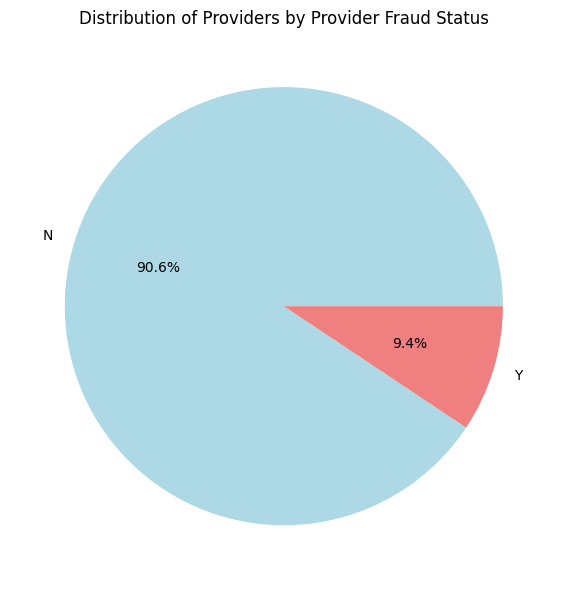

In [467]:
plt.figure(figsize=(8, 6))

labels=['N', 'Y']
colors = ['lightblue', 'lightcoral'] 

plt.pie(provider['fraud_suspected'].value_counts().sort_index(), 
            labels=labels, 
            colors=colors,
            autopct='%1.1f%%')

plt.title('Distribution of Providers by Provider Fraud Status')
plt.tight_layout()
plt.show()

In [166]:
provider

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.0,1.000000,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.642857,380.000000,820.880286,72.928571,8.852405,2.142857,6.299408,384.642857,822.230400,10770.0,0.983401,0.070643,3.0,1.428571,5.250000,10.0,28.0,0.035714,0.035714,0.035714,0.857143,7.0,7.0,2.3

In [167]:
# separate fraud observations from non-fraud observations
fraud = provider[provider['fraud_suspected']==1]
non_fraud = provider[provider['fraud_suspected']==0]

In [168]:
fraud

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
1,PRV51003,1068.00,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.000000,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.000000,32670.0,1,1,1
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.000000,280910.0,0,1,1
13,PRV51021,1068.00,9275.862069,10277.911655,28.0,69.827586,12.733726,4.758621,3.429444,4.793103,3.457696,10343.862069,10277.911655,299972.0,0.799094,0.233699,2.0,1.689655,6.034483,10.0,29.0,0.241379,0.241379,0.034483,0.793103,21.0,24.0,2.416667,8.517241,0.758621,269000.0,2.280702,350.131579,631.239938,72.385965,13.199926,1.644737,5.089604,352.412281,632.068743,80350.0,0.953894,0.195746,2.0,1.561404,4.548246,9.0,228.0,0.293860,0.100877,0.179825,0.820175,27.0,44.0,19.000000,2.780702,0.000000,79830.0,1,1,1
25,PRV51037,1068.00,9304.347826,5849.901185,23.0,70.347826,14.636842,4.565217,4.099070,4.521739,4.132681,10372.347826,5849.901185,238564.0,0.866731,0.061311,2.0,1.565217,6.000000,8.0,23.0,0.043478,0.043478,0.000000,0.913043,18.0,18.0,1.916667,8.043478,0.565217,214000.0,2.227378,297.517401,579.186365,71.480278,14.421526,1.373550,4.686661,299.744780,578.934611,129190.0,0.937188,0.231356,2.0,1.575406,4.584687,11.0,431.0,0.004640,0.004640,0.002320,0.468677,30.0,59.0,35.916667,2.716937,0.000000,128230.0,1,1,1
37,PRV51052,1068.00,7000.000000,2828.427125,2.0,73.000000,7.071068,9.000000,7.071068,9.000000,7.071068,8068.000000,2828.427125,16136.0,0.858958,0.049446,1.0,1.500000,6.000000,8.0,2.0,1.000000,0.500000,0.000000,1.000000,2.0,2.0,0.166667,8.500000,0.500000,14000.0,4.772727,381.818182,710.726038,71.045455,13.607376,1.977273,5.816931,386.590909,709.329664,17010.0,0.923887,0.238179,2.0,1.545455,4.068182,10.0,44.0,0.363636,0.113636,0.136364,0.818182,15.0,18.0,3.666667,3.045455,0.000000,16800.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307,PRV57642,1068.00,12521.739130,13740.681355,23.0,71.695652,10.257746,6.347826,7.258905,6.347826,7.258905,13589.739130,13740.681

In [169]:
non_fraud

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.0,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.0,1.0,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0
5,PRV51008,1068.0,12500.000000,12020.815280,2.0,50.500000,31.819805,4.000000,1.414214,4.000000,1.414214,13568.000000,12020.815280,27136.0,0.870435,0.114790,1.0,1.500000,3.500000,4.0,2.0,1.000000,1.000000,0.0,1.0,2.0,2.0,0.166667,7.500000,1.000000,25000.0,4.390244,259.268293,404.038304,75.780488,10.132897,1.414634,4.483166,263.658537,406.206574,10810.0,0.966410,0.160144,2.0,1.560976,3.926829,8.0,41.0,0.195122,0.073171,0.121951,0.829268,8.0,8.0,3.416667,2.951220,0.0,10630.0,1,1,0
6,PRV51011,1068.0,5000.000000,0.000000,1.0,97.000000,0.000000,5.000000,0.000000,5.000000,0.000000,6068.000000,0.000000,6068.0,0.823995,0.000000,1.0,2.000000,7.000000,7.0,1.0,1.000000,0.000000,0.0,1.0,1.0,1.0,0.083333,8.000000,0.000000,5000.0,5.263158,204.035088,310.787362,73.017544,12.784605,0.473684,2.353609,209.298246,313.179887,11930.0,0.940388,0.210530,2.0,1.526316,4.543860,9.0,57.0,0.473684,0.175439,0.263158,0.912281,12.0,11.0,4.750000,2.438596,0.0,11630.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.642857,380.000000,820.880286,72.928571,8.852405,2.142857,6.299408,384.642857,822.230400,10770.0,0.983401,0.07

In [170]:
# randomly create a sample of 506 observations from the non_fraud data
legit_sample = non_fraud.sample(n=506)

In [171]:
legit_sample

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
2103,PRV53624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.167832,285.244755,548.448300,73.713287,12.709441,1.307692,4.393066,287.412587,547.522864,41100.0,0.940793,0.233113,4.0,1.608392,4.391608,10.0,143.0,0.559441,0.104895,0.230769,0.979021,24.0,32.0,11.916667,2.510490,0.0,40790.0,0,1,0
616,PRV51767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.666667,338.333333,808.172274,71.583333,14.718315,0.083333,0.288675,355.000000,804.865884,4260.0,0.944444,0.192450,1.0,1.666667,3.916667,8.0,12.0,0.166667,0.083333,0.166667,1.000000,5.0,5.0,1.000000,3.333333,0.0,4060.0,0,1,0
3981,PRV55981,1068.0,6800.0,4693.460496,15.0,81.200,9.166710,3.533333,1.641718,3.533333,1.641718,7868.0,4693.460496,118020.0,0.778111,0.233185,2.0,1.666667,5.600,10.0,15.0,0.8,0.533333,0.20,1.0,13.0,14.0,1.250000,7.733333,0.533333,102000.0,3.333333,208.717949,398.419109,71.179487,14.266028,1.102564,4.121796,212.051282,397.281416,8270.0,0.944444,0.203526,3.0,1.641026,4.589744,9.0,39.0,0.487179,0.205128,0.205128,1.000000,10.0,10.0,3.250000,2.948718,0.0,8140.0,1,1,0
2787,PRV54469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,299.090909,341.685661,68.363636,11.876639,0.090909,0.301511,299.090909,341.685661,3290.0,1.000000,0.000000,3.0,1.545455,3.818182,7.0,11.0,0.181818,0.090909,0.272727,0.909091,5.0,5.0,0.916667,3.090909,0.0,3290.0,0,1,0
4944,PRV57197,1068.0,12250.0,8013.381665,8.0,68.625,6.588681,8.750000,10.024969,8.750000,10.024969,13318.0,8013.381665,106544.0,0.887675,0.073365,2.0,1.625000,6.625,9.0,8.0,0.5,0.625000,0.25,1.0,6.0,7.0,0.666667,8.000000,0.875000,98000.0,2.173913,190.652174,360.764769,70.195652,15.548039,1.043478,3.802582,192.826087,360.266465,17740.0,0.918086,0.260781,4.0,1.652174,4.760870,9.0,92.0,0.119565,0.086957,0.065217,0.500000,22.0,26.0,7.666667,2.684783,0.0,17540.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,PRV53997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.802326,408.313953,721.962931,72.424419,13.537044,2.308140,6.195956,410.116279,721.529393,70540.0,0.977806,0.126685,2.0,1.610465,4.872093,10.0,172.0,0.011628,0.005814,0.011628,0.552326,24.0,31.0,14.333333,2.790698,0.0,70230.0,0,1,0
5224,PRV57540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

In [172]:
# concatenate real fraud samples and randomly generated legit samples to create balanced dataset
undersampled = pd.concat([legit_sample, fraud], axis=0)

In [173]:
undersampled

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
2103,PRV53624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.167832,285.244755,548.448300,73.713287,12.709441,1.307692,4.393066,287.412587,547.522864,41100.0,0.940793,0.233113,4.0,1.608392,4.391608,10.0,143.0,0.559441,0.104895,0.230769,0.979021,24.0,32.0,11.916667,2.510490,0.000000,40790.0,0,1,0
616,PRV51767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.666667,338.333333,808.172274,71.583333,14.718315,0.083333,0.288675,355.000000,804.865884,4260.0,0.944444,0.192450,1.0,1.666667,3.916667,8.0,12.0,0.166667,0.083333,0.166667,1.000000,5.0,5.0,1.000000,3.333333,0.000000,4060.0,0,1,0
3981,PRV55981,1068.00,6800.000000,4693.460496,15.0,81.200000,9.166710,3.533333,1.641718,3.533333,1.641718,7868.000000,4693.460496,118020.0,0.778111,0.233185,2.0,1.666667,5.600000,10.0,15.0,0.800000,0.533333,0.200000,1.000000,13.0,14.0,1.250000,7.733333,0.533333,102000.0,3.333333,208.717949,398.419109,71.179487,14.266028,1.102564,4.121796,212.051282,397.281416,8270.0,0.944444,0.203526,3.0,1.641026,4.589744,9.0,39.0,0.487179,0.205128,0.205128,1.000000,10.0,10.0,3.250000,2.948718,0.000000,8140.0,1,1,0
2787,PRV54469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,299.090909,341.685661,68.363636,11.876639,0.090909,0.301511,299.090909,341.685661,3290.0,1.000000,0.000000,3.0,1.545455,3.818182,7.0,11.0,0.181818,0.090909,0.272727,0.909091,5.0,5.0,0.916667,3.090909,0.000000,3290.0,0,1,0
4944,PRV57197,1068.00,12250.000000,8013.381665,8.0,68.625000,6.588681,8.750000,10.024969,8.750000,10.024969,13318.000000,8013.381665,106544.0,0.887675,0.073365,2.0,1.625000,6.625000,9.0,8.0,0.500000,0.625000,0.250000,1.000000,6.0,7.0,0.666667,8.000000,0.875000,98000.0,2.173913,190.652174,360.764769,70.195652,15.548039,1.043478,3.802582,192.826087,360.266465,17740.0,0.918086,0.260781,4.0,1.652174,4.760870,9.0,92.0,0.119565,0.086957,0.065217,0.500000,22.0,26.0,7.666667,2.684783,0.000000,17540.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307,PRV57642,1068.00,12521.739130,13740.681355,23.0,71.695652,10.257746,6.347826,7.258905,6.347826,7.258905,13589.739130,13740.681355,312564.0,0.835025,0.194433,1.0,1.521739,5.913043,8.0,23.0,0.086957,0.086957,0.043478,0.739130,17.0,17.0,1.916667,8.130435,0.913043,288000.0,3.553299,169.898477,358.007510,72.609137,10.320107,0.949239,3.764423,173.451777,357.722763,34170.0,0.936861,0.236513,1.0,1.583756,3.954315,10

In [174]:
# drop unique identifier (provider)
undersampled = undersampled.drop(columns=['Provider'], axis=1)

In [175]:
# group by fraud status and look at mean values
undersampled.groupby('fraud_suspected').mean()

,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice
fraud_suspected,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1045.182859,9804.018525,7396.414157,10.982036,72.362366,10.670128,5.743369,4.100910,5.741913,4.100045,10849.201384,7393.878824,121486.299401,0.82788,0.126378,1.772455,1.578506,5.450332,7.958084,11.257485,0.627097,0.436605,0.143865,0.970480,7.892216,9.766467,0.938124,8.075683,0.753625,109693.532934,2.723650,300.665898,504.707648,72.540883,11.795569,1.395600,3.831110,303.389547,504.840412,22356.506494,0.944235,0.165307,2.532468,1.585422,4.360628,8.322511,76.354978,0.382579,0.108231,0.198248,0.829981,10.560606,14.417749,6.362915,2.632784,0.000249,22140.454545,0.330040,0.913043
1,1043.070135,11046.244346,10632.883234,47.613636,73.078324,12.618963,6.113498,6.318736,6.110839,6.313698,12089.314481,10633.407355,603952.959091,0.84208,0.144308,2.568182,1.577063,5.552846,9.143182,53.186364,0.352931,0.251637,0.088206,0.895637,21.052273,32.590909,4.432197,8.105750,0.757263,548382.977273,4.821369,518.724669,691.823982,72.591271,12.744290,1.469457,4.511447,523.546038,693.255659,118870.322511,0.948123,0.191204,3.320346,1.577502,4.421227,9.322511,409.943723,0.358471,0.104047,0.187284,0.760297,23.090909,40.266234,34.161977,2.632825,0.004943,117732.922078,0.869565,0.913043


### Fraud stats for provider df

look at similar stats for the unbalanced dataset (the 'original' provider data). This data still has NaN values for missing data, which is ignored when calculating stats.

[Contents](#Contents)

In [177]:
provider.head()

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.0,1.000000,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0


In [178]:
provider_fraud_stats = provider.drop(columns=['Provider'], axis=1)
provider_fraud_stats = provider_fraud_stats.groupby('fraud_suspected').mean()
provider_fraud_stats.reset_index(inplace=True)

In [179]:
provider_fraud_stats

,fraud_suspected,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice
0,0,1042.542505,9984.863110,7207.725608,10.050242,73.106300,10.375719,5.545982,3.842907,5.540683,3.839002,11027.405615,7207.546179,111878.824455,0.831014,0.117319,1.757264,1.578807,5.485309,7.822639,10.334140,0.637243,0.419421,0.126234,0.958396,7.377724,8.965496,0.861178,8.094658,0.729859,101094.739709,2.772843,282.616722,487.682171,72.681769,11.753408,1.362007,3.769107,285.389566,487.900367,20827.899560,0.943452,0.163056,2.451209,1.583038,4.378480,8.203297,72.163297,0.397462,0.114688,0.208590,0.826920,9.958901,13.681319,6.013608,2.610734,0.000265,20627.145055,0.336868,0.927814
1,1,1043.070135,11046.244346,10632.883234,47.613636,73.078324,12.618963,6.113498,6.318736,6.110839,6.313698,12089.314481,10633.407355,603952.959091,0.842080,0.144308,2.568182,1.577063,5.552846,9.143182,53.186364,0.352931,0.251637,0.088206,0.895637,21.052273,32.590909,4.432197,8.105750,0.757263,548382.977273,4.821369,518.724669,691.823982,72.591271,12.744290,1.469457,4.511447,523.546038,693.255659,118870.322511,0.948123,0.191204,3.320346,1.577502,4.421227,9.322511,409.943723,0.358471,0.104047,0.187284,0.760297,23.090909,40.266234,34.161977,2.632825,0.004943,117732.922078,0.869565,0.913043


In [180]:
def plot_fraud_comparisons(df):
    """
    Creates comparison plots for all features between fraud classes.
    """
    
    # Get all feature columns (exclude fraud_suspected)
    feature_cols = [col for col in df.columns if col != 'fraud_suspected']
    
    # Separate _ip and _op features
    ip_features = [col for col in feature_cols if col.endswith('_ip')]
    op_features = [col for col in feature_cols if col.endswith('_op')]
    
    # Find matching pairs
    feature_pairs = []
    for ip_feat in ip_features:
        base_name = ip_feat[:-3]  # Remove '_ip'
        op_feat = base_name + '_op'
        if op_feat in op_features:
            feature_pairs.append((base_name, ip_feat, op_feat))
    
    print(f"📊 Found {len(feature_pairs)} feature pairs")
    print(f"📊 Found {len(ip_features)} IP features")
    print(f"📊 Found {len(op_features)} OP features")
    
    # Colors for fraud classes
    colors = ['#2ecc71', '#e74c3c']  # Green for no fraud, Red for fraud
    
    # ===== 1. PAIRED COMPARISON (IP vs OP side-by-side) =====
    if feature_pairs:
        n_pairs = len(feature_pairs)
        n_cols = 3
        n_rows = int(np.ceil(n_pairs / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
        fig.suptitle('Healthcare Fraud Analysis: IP vs OP Feature Comparison\nFraud Suspected (0 = No, 1 = Yes)', 
                     fontsize=16, fontweight='bold')
        
        # Flatten axes for easier iteration
        if n_pairs > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        for idx, (base_name, ip_feat, op_feat) in enumerate(feature_pairs):
            ax = axes[idx]
            
            # Prepare data
            x = np.arange(2)  # Two fraud classes
            width = 0.35
            
            ip_values = df.groupby('fraud_suspected')[ip_feat].mean().values
            op_values = df.groupby('fraud_suspected')[op_feat].mean().values
            
            # Create grouped bars
            bars1 = ax.bar(x - width/2, ip_values, width, label='Inpatient', 
                          color='#3498db', alpha=0.7, edgecolor='black')
            bars2 = ax.bar(x + width/2, op_values, width, label='Outpatient', 
                          color='#f39c12', alpha=0.7, edgecolor='black')
            
            # Formatting
            ax.set_xlabel('', fontsize=9)
            ax.set_ylabel('Value', fontsize=9)
            ax.set_title(base_name.replace('_', ' ').title(), fontweight='bold', fontsize=10)
            ax.set_xticks(x)
            ax.set_xticklabels(['No (0)', 'Yes (1)'])
            ax.legend(fontsize=8)
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom', fontsize=7)
        
        # Hide extra subplots
        for idx in range(n_pairs, len(axes)):
            axes[idx].axis('off')
        
        #plt.tight_layout()
        plt.show()

📊 Found 27 feature pairs
📊 Found 30 IP features
📊 Found 27 OP features


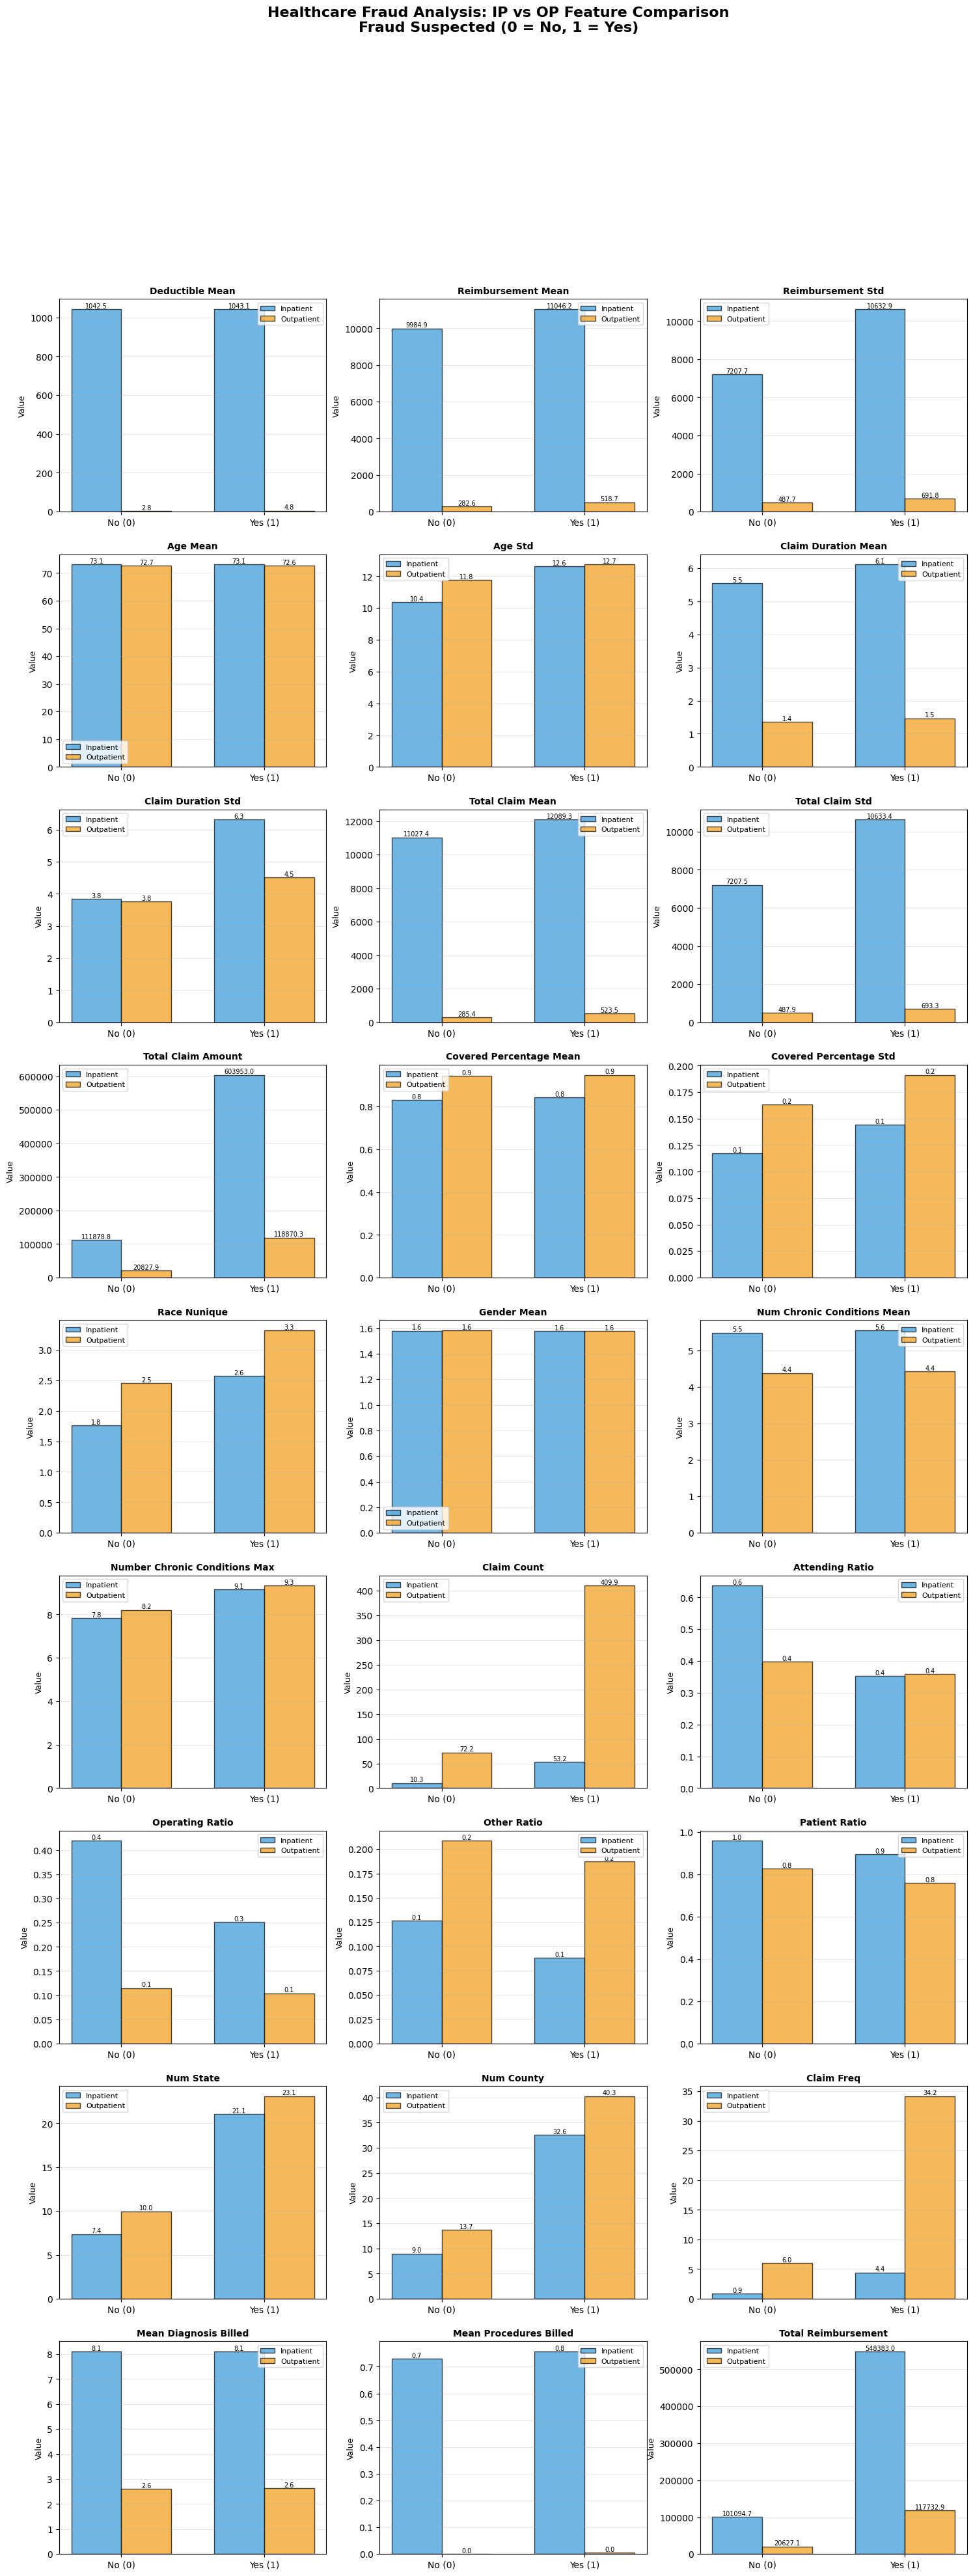

In [181]:
summary = plot_fraud_comparisons(provider_fraud_stats)

In [182]:
def plot_fraud_comparison_heatmap(df):
    """
    Creates heatmap with feature differences between fraud classes.
    """
    
    # DEBUG: Check what dataframe we're actually using
    print("DEBUG - First few rows of input dataframe:")
    print(df[['fraud_suspected', 'mean_procedures_billed_op', 'mean_procedures_billed_ip']].head())
    print()
    
    # Get all feature columns (exclude fraud_suspected and any with 'ratio')
    feature_cols = [col for col in df.columns 
                    if col != 'fraud_suspected' and 'ratio' not in col.lower()]
    
    # Separate _ip and _op features
    ip_features = [col for col in feature_cols if col.endswith('_ip')]
    op_features = [col for col in feature_cols if col.endswith('_op')]
    
    # Find matching pairs
    feature_pairs = []
    for ip_feat in ip_features:
        base_name = ip_feat[:-3]  # Remove '_ip'
        op_feat = base_name + '_op'
        if op_feat in op_features:
            feature_pairs.append((base_name, ip_feat, op_feat))
    
    print(f"📊 Found {len(feature_pairs)} feature pairs")
    print(f"📊 Found {len(ip_features)} IP features")
    print(f"📊 Found {len(op_features)} OP features")
    
    # Colors for fraud classes
    colors = ['#2ecc71', '#e74c3c']  # Green for no fraud, Red for fraud
            
    # ===== 2. HEATMAP OF SCALE DIFFERENCES =====
    if len(feature_cols) > 0:
        fig, ax = plt.subplots(figsize=(10, max(8, len(feature_cols) * 0.3)))
        
        # Get the correct rows based on fraud_suspected value
        no_fraud_row = df[df['fraud_suspected'] == 0].iloc[0]
        fraud_row = df[df['fraud_suspected'] == 1].iloc[0]
        
        # Calculate mean values for each class
        summary_data = []
        for feat in feature_cols:
            class_0 = no_fraud_row[feat]
            class_1 = fraud_row[feat]
            scale_diff = (class_1 / class_0) if class_0 != 0 else 0
            summary_data.append([class_0, class_1, scale_diff])
        
        summary_df = pd.DataFrame(summary_data, 
                                 columns=['No Fraud (0)', 'Fraud (1)', 'Scale'],
                                 index=[f.replace('_', ' ').title() for f in feature_cols]).sort_values(by=['Scale'], ascending=False)
        
        # Create heatmap for scale difference
        im = ax.imshow(summary_df[['Scale']].values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=3)
        
        ax.set_xticks([0])
        ax.set_xticklabels(['Scale difference in features (Fraud vs No Fraud); does not include _ratio_ features'])
        ax.set_yticks(np.arange(len(feature_cols)))
        ax.set_yticklabels(summary_df.index, fontsize=8)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Scale difference', rotation=270, labelpad=15)
        
        # Add text annotations
        for i in range(len(feature_cols)):
            text = ax.text(0, i, f'{summary_df.iloc[i]["Scale"]:.2f}x',
                          ha="center", va="center", color="black", fontsize=7, fontweight='bold')
        
        ax.set_title('Feature Scale Differences: Fraud vs No Fraud\n(Red = Higher in Fraud, Green = Lower in Fraud)', 
                    fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Print summary table
        print("\n" + "="*80)
        print("SUMMARY TABLE")
        print("="*80)
        print(summary_df.to_string())
        
        return summary_df

DEBUG - First few rows of input dataframe:
   fraud_suspected  mean_procedures_billed_op  mean_procedures_billed_ip
0                0                   0.000265                   0.729859
1                1                   0.004943                   0.757263

📊 Found 21 feature pairs
📊 Found 22 IP features
📊 Found 21 OP features


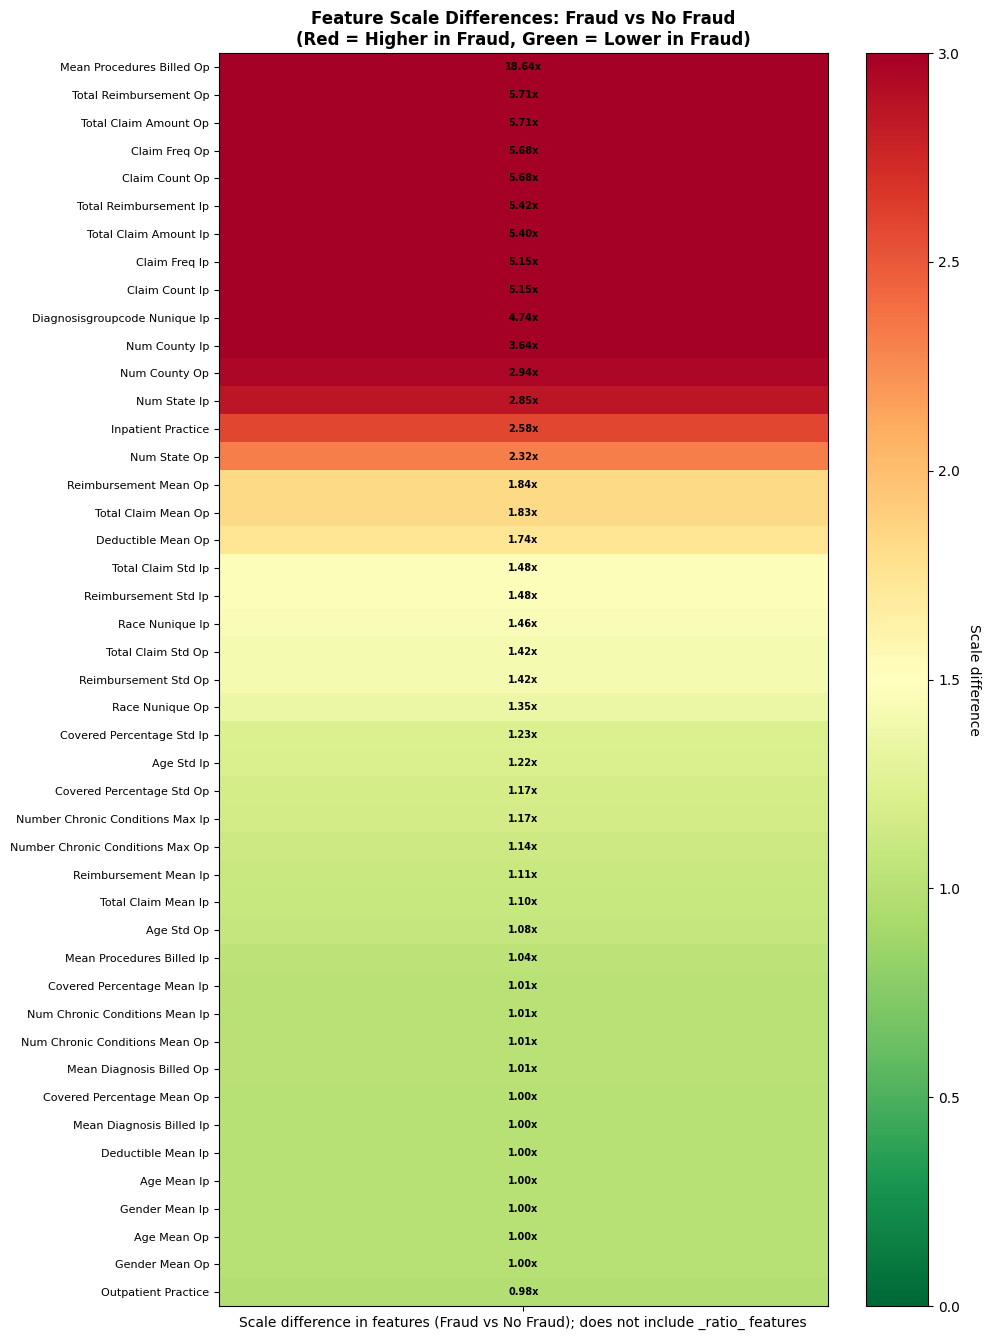


SUMMARY TABLE
                                   No Fraud (0)      Fraud (1)      Scale
Mean Procedures Billed Op              0.000265       0.004943  18.644053
Total Reimbursement Op             20627.145055  117732.922078   5.707669
Total Claim Amount Op              20827.899560  118870.322511   5.707264
Claim Freq Op                          6.013608      34.161977   5.680779
Claim Count Op                        72.163297     409.943723   5.680779
Total Reimbursement Ip            101094.739709  548382.977273   5.424446
Total Claim Amount Ip             111878.824455  603952.959091   5.398278
Claim Freq Ip                          0.861178       4.432197   5.146665
Claim Count Ip                        10.334140      53.186364   5.146665
Diagnosisgroupcode Nunique Ip         10.050242      47.613636   4.737561
Num County Ip                          8.965496      32.590909   3.635148
Num County Op                         13.681319      40.266234   2.943154
Num State Ip           

,No Fraud (0),Fraud (1),Scale
Mean Procedures Billed Op,0.000265,0.004943,18.644053
Total Reimbursement Op,20627.145055,117732.922078,5.707669
Total Claim Amount Op,20827.899560,118870.322511,5.707264
Claim Freq Op,6.013608,34.161977,5.680779
Claim Count Op,72.163297,409.943723,5.680779
Total Reimbursement Ip,101094.739709,548382.977273,5.424446
Total Claim Amount Ip,111878.824455,603952.959091,5.398278
Claim Freq Ip,0.861178,4.432197,5.146665
Claim Count Ip,10.334140,53.186364,5.146665
Diagnosisgroupcode Nunique Ip,10.050242,47.613636,4.737561


In [183]:
plot_fraud_comparison_heatmap(provider_fraud_stats)

In [184]:
provider_fraud_stats[['mean_procedures_billed_op', 'mean_procedures_billed_ip']]

,mean_procedures_billed_op,mean_procedures_billed_ip
0,0.000265,0.729859
1,0.004943,0.757263


### Data imputed with 0s

In [186]:
# The above is for provider with NaNs. Look at these stats again with data that has been imputed with 0s. 
provider_with_zeros = provider.copy()
provider_with_zeros = provider_with_zeros.drop(columns=['Provider'], axis=1)
provider_with_zeros = provider_with_zeros.fillna(0)

📊 Found 27 feature pairs
📊 Found 30 IP features
📊 Found 27 OP features


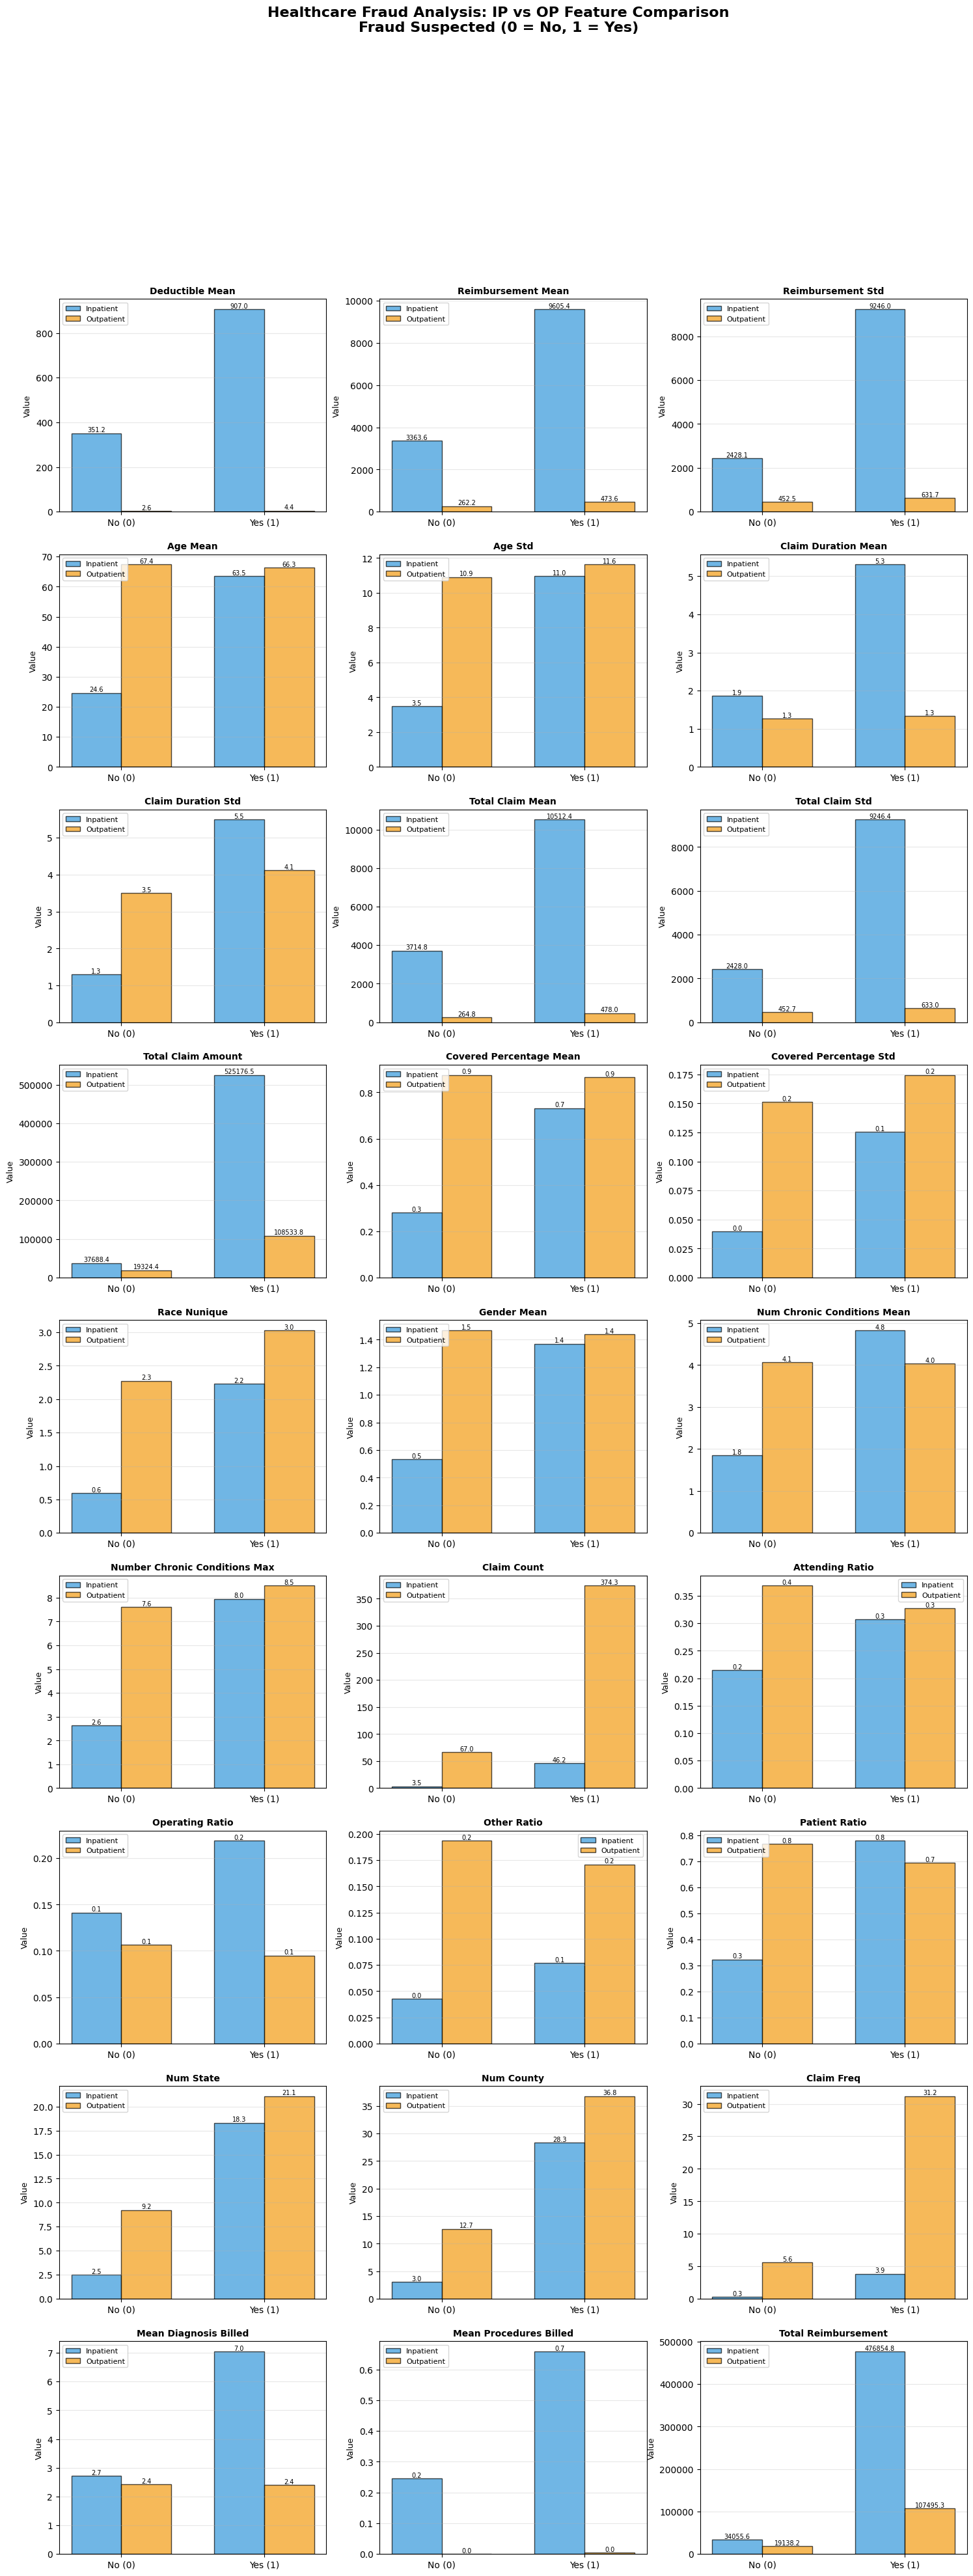

In [187]:
summary = plot_fraud_comparisons(provider_with_zeros)

DEBUG - First few rows of input dataframe:
   fraud_suspected  mean_procedures_billed_op  mean_procedures_billed_ip
0                0                        0.0                   0.600000
1                1                        0.0                   0.774194
2                0                        0.0                   0.000000
3                1                        0.0                   0.000000
4                0                        0.0                   0.333333

📊 Found 21 feature pairs
📊 Found 22 IP features
📊 Found 21 OP features


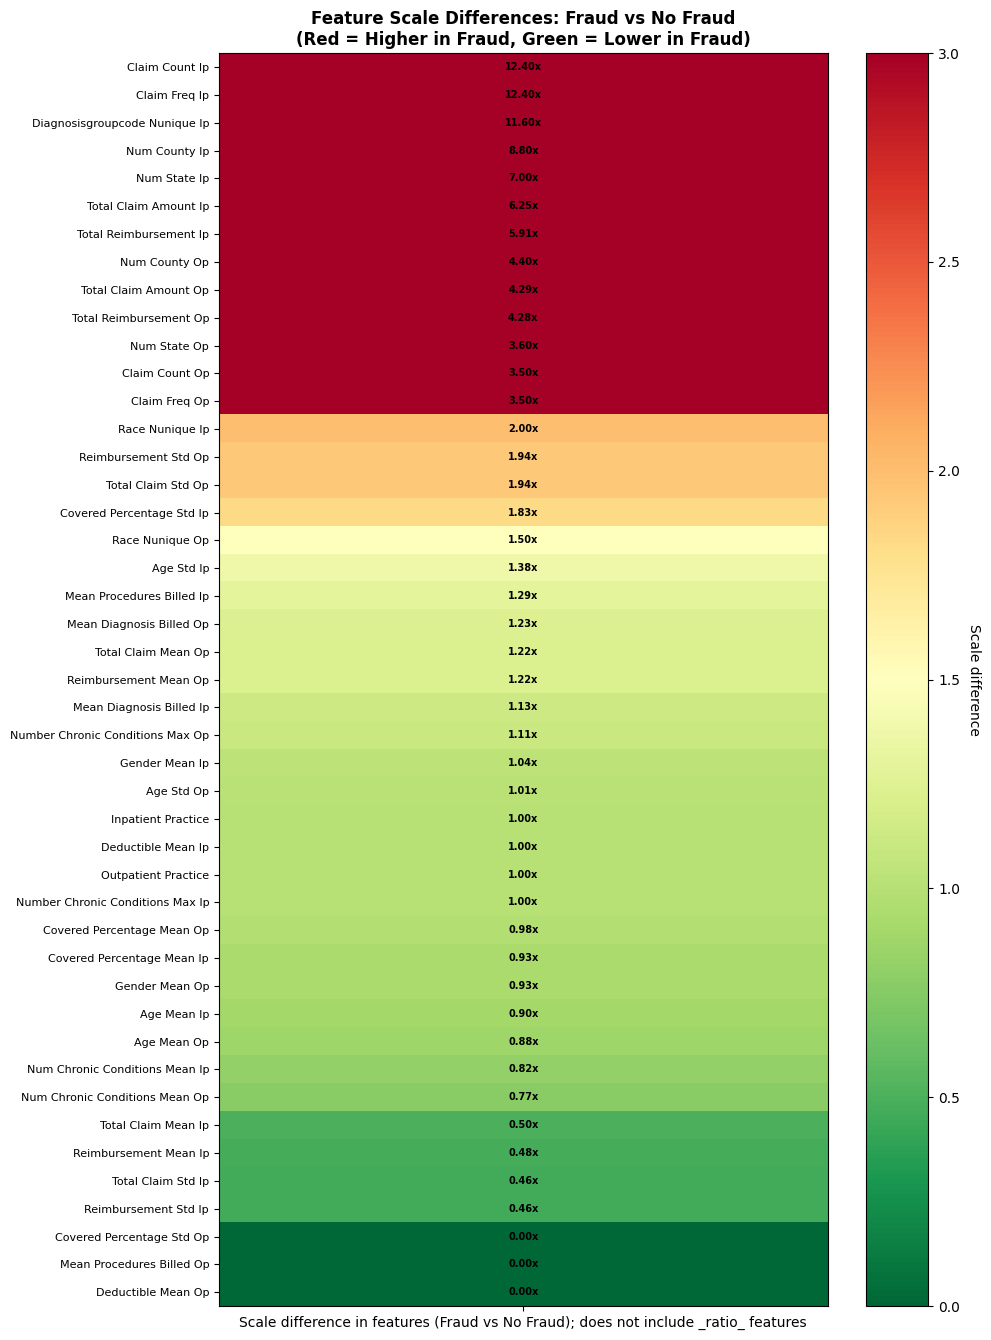


SUMMARY TABLE
                                   No Fraud (0)      Fraud (1)      Scale
Claim Count Ip                         5.000000      62.000000  12.400000
Claim Freq Ip                          0.416667       5.166667  12.400000
Diagnosisgroupcode Nunique Ip          5.000000      58.000000  11.600000
Num County Ip                          5.000000      44.000000   8.800000
Num State Ip                           4.000000      28.000000   7.000000
Total Claim Amount Ip             102340.000000  639216.000000   6.246004
Total Reimbursement Ip             97000.000000  573000.000000   5.907216
Num County Op                          5.000000      22.000000   4.400000
Total Claim Amount Op               7640.000000   32740.000000   4.285340
Total Reimbursement Op              7640.000000   32670.000000   4.276178
Num State Op                           5.000000      18.000000   3.600000
Claim Count Op                        20.000000      70.000000   3.500000
Claim Freq Op          

,No Fraud (0),Fraud (1),Scale
Claim Count Ip,5.000000,62.000000,12.400000
Claim Freq Ip,0.416667,5.166667,12.400000
Diagnosisgroupcode Nunique Ip,5.000000,58.000000,11.600000
Num County Ip,5.000000,44.000000,8.800000
Num State Ip,4.000000,28.000000,7.000000
Total Claim Amount Ip,102340.000000,639216.000000,6.246004
Total Reimbursement Ip,97000.000000,573000.000000,5.907216
Num County Op,5.000000,22.000000,4.400000
Total Claim Amount Op,7640.000000,32740.000000,4.285340
Total Reimbursement Op,7640.000000,32670.000000,4.276178


In [188]:
plot_fraud_comparison_heatmap(provider_with_zeros)

In [189]:
provider.head()

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.0,1.000000,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0


In [190]:
provider_with_zeros.head()

,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.600000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.000000,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.661290,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.000000,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,2.080537,350.134228,689.963754,71.261745,12.936120,1.429530,4.783495,352.214765,689.593344,52480.0,0.945650,0.216273,3.0,1.691275,4.342282,9.0,149.0,0.255034,0.127517,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,3.175966,241.124464,491.556392,69.526180,13.348760,1.088412,4.107437,244.300429,491.462817,284610.0,0.952124,0.195525,3.0,1.561373,4.335622,9.0,1165.0,0.005150,0.005150,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,1.527525,7401.333333,3511.884584,22204.0,0.829955,0.084626,1.0,1.666667,5.666667,6.0,3.0,0.666667,0.333333,0.0,1.000000,3.0,3.0,0.250000,7.333333,0.333333,19000.0,0.869565,213.188406,447.231657,67.898551,14.781890,0.768116,3.383111,214.057971,447.030460,14770.0,0.977778,0.128168,2.0,1.521739,4.101449,8.0,69.0,0.115942,0.057971,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0


In [191]:
print(provider.groupby('fraud_suspected')['total_reimbursement_ip'].mean())
print(provider_with_zeros.groupby('fraud_suspected')['total_reimbursement_ip'].mean())

fraud_suspected
0    101094.739709
1    548382.977273
Name: total_reimbursement_ip, dtype: float64
fraud_suspected
0     34055.568923
1    476854.762846
Name: total_reimbursement_ip, dtype: float64


Expect that zero means will be lower than nan means. that checks.

In [193]:
print(provider.groupby('fraud_suspected')['total_claim_amount_ip'].mean())
print(provider_with_zeros.groupby('fraud_suspected')['total_claim_amount_ip'].mean())

fraud_suspected
0    111878.824455
1    603952.959091
Name: total_claim_amount_ip, dtype: float64
fraud_suspected
0     37688.380506
1    525176.486166
Name: total_claim_amount_ip, dtype: float64


### Understanding bias

Understanding bias introduced into the model by imputing NaNs with 0s

In [195]:
mean_with_nans = provider.groupby('fraud_suspected')['total_reimbursement_ip'].mean()
mean_with_zeros = provider_with_zeros.groupby('fraud_suspected')['total_reimbursement_ip'].mean()
print(mean_with_nans)
print(mean_with_zeros)

fraud_suspected
0    101094.739709
1    548382.977273
Name: total_reimbursement_ip, dtype: float64
fraud_suspected
0     34055.568923
1    476854.762846
Name: total_reimbursement_ip, dtype: float64


Excluding NaNs (leaving NaNs as is), the average total inpatient reimbursement is:
- non-fraud providers: 101,095 dollars
- fraud providers: 548,383 dollars

Imputing with 0s, the average total is:
- non-fraud providers: 34,056 dollars
- fraud providers: 476,855 dollars

- With NaN data, fraud providers have a total reimbursement that is more than 5 times non-fraud providers.
- With 0s imputed, fraud providers have a total reimbursement that is 14 times non-fraud providers

In [197]:
nan_counts = provider['total_reimbursement_ip'].isnull().sum()
nan_counts

3318

In [198]:
bias = mean_with_zeros - mean_with_nans
bias

fraud_suspected
0   -67039.170786
1   -71528.214427
Name: total_reimbursement_ip, dtype: float64

In [199]:
percent_bias = ((mean_with_zeros - mean_with_nans) / mean_with_nans * 100)
percent_bias

fraud_suspected
0   -66.313214
1   -13.043478
Name: total_reimbursement_ip, dtype: float64

- Non-fraud providers lose 66% of their mean total inpatient reimbursement due to zero imputation.
- Fraud providers lose 13%

In [201]:
bias_summary = []

for feat in provider.columns:
    if feat == 'fraud_suspected':
        continue

    # skip non-numeric columns
    if not pd.api.types.is_numeric_dtype(provider[feat]):
        continue
        
    # calculate for fraud_suspected = 0
    mean_nans_0 = provider[provider['fraud_suspected'] == 0][feat].mean()
    mean_zeros_0 = provider_with_zeros[provider_with_zeros['fraud_suspected'] == 0][feat].mean()
    n_missing_0 = provider[provider['fraud_suspected'] == 0][feat].isna().sum()
    n_total_0 = len(provider[provider['fraud_suspected'] == 0])
    
    bias_summary.append({
        'feature': feat,
        'fraud_suspected': 0,
        'n_total': n_total_0,
        'n_missing': n_missing_0,
        'pct_missing': (n_missing_0 / n_total_0) * 100,
        'mean_excluding_nan': mean_nans_0,
        'mean_with_zeros': mean_zeros_0,
        'absolute_bias': mean_zeros_0 - mean_nans_0,
        'percent_bias': ((mean_zeros_0 - mean_nans_0) / mean_nans_0) * 100
    })
    
    # calculate for fraud_suspected = 1
    mean_nans_1 = provider[provider['fraud_suspected'] == 1][feat].mean()
    mean_zeros_1 = provider_with_zeros[provider_with_zeros['fraud_suspected'] == 1][feat].mean()
    n_missing_1 = provider[provider['fraud_suspected'] == 1][feat].isna().sum()
    n_total_1 = len(provider[provider['fraud_suspected'] == 1])
    
    bias_summary.append({
        'feature': feat,
        'fraud_suspected': 1,
        'n_total': n_total_1,
        'n_missing': n_missing_1,
        'pct_missing': (n_missing_1 / n_total_1) * 100,
        'mean_excluding_nan': mean_nans_1,
        'mean_with_zeros': mean_zeros_1,
        'absolute_bias': mean_zeros_1 - mean_nans_1,
        'percent_bias': ((mean_zeros_1 - mean_nans_1) / mean_nans_1) * 100
    })

bias_summary = pd.DataFrame(bias_summary)

In [202]:
bias_sorted = bias_summary.sort_values(by=['percent_bias'], ascending=True)

In [203]:
bias_sorted['percent_bias'].value_counts()

percent_bias
-66.313214    15
-66.313214    15
-13.043478     8
-8.695652      6
-13.043478     6
-7.218597      5
-8.695652      4
 0.000000      4
-13.043478     4
-13.043478     3
-13.043478     3
-8.695652      3
-8.695652      3
-7.218597      3
-7.218597      2
-8.695652      2
-8.695652      2
-7.218597      2
-7.218597      2
-7.218597      2
-13.043478     2
-7.218597      2
-13.043478     2
-7.218597      2
-7.218597      1
-7.218597      1
-7.218597      1
-13.043478     1
-7.218597      1
-7.218597      1
-7.218597      1
-8.695652      1
-8.695652      1
-8.695652      1
-8.695652      1
-8.695652      1
-8.695652      1
-8.695652      1
-13.043478     1
-7.218597      1
Name: count, dtype: int64

In [204]:
bias_sorted[bias_sorted['percent_bias']<=-60]

,feature,fraud_suspected,n_total,n_missing,pct_missing,mean_excluding_nan,mean_with_zeros,absolute_bias,percent_bias
0,deductible_mean_ip,0,4904,3252,66.313214,1042.542505,351.199066,-691.343440,-66.313214
22,total_claim_std_ip,0,4904,3252,66.313214,7207.546179,2427.990679,-4779.555501,-66.313214
20,total_claim_mean_ip,0,4904,3252,66.313214,11027.405615,3714.778564,-7312.627052,-66.313214
30,Race_nunique_ip,0,4904,3252,66.313214,1.757264,0.591966,-1.165298,-66.313214
34,num_chronic_conditions_mean_ip,0,4904,3252,66.313214,5.485309,1.847824,-3.637485,-66.313214
38,claim_count_ip,0,4904,3252,66.313214,10.334140,3.481240,-6.852901,-66.313214
14,inpatient_duration_std_ip,0,4904,3252,66.313214,3.842907,1.294552,-2.548355,-66.313214
26,covered_percentage_mean_ip,0,4904,3252,66.313214,0.831014,0.279942,-0.551072,-66.313214
42,operating_ratio_ip,0,4904,3252,66.313214,0.419421,0.141290,-0.278132,-66.313214
10,age_std_ip,0,4904,3252,66.313214,10.375719,3.495246,-6.880472,-66.313214


In [205]:
bias_sorted['pct_missing'].value_counts()

pct_missing
66.313214    30
13.043478    30
8.695652     27
7.218597     27
0.000000      4
Name: count, dtype: int64

So, this missingness is predictive of fraud status? 

In [207]:
9*4*9*5

1620

In [208]:
print("Correlation between NaN and practice type:")
print(f"IP features NaN when inpatient_practice=0: {(provider['total_reimbursement_ip'].isna() == (provider['inpatient_practice'] == 0)).mean()*100:.1f}%")
print(f"OP features NaN when outpatient_practice=0: {(provider['total_reimbursement_op'].isna() == (provider['outpatient_practice'] == 0)).mean()*100:.1f}%")

Correlation between NaN and practice type:
IP features NaN when inpatient_practice=0: 100.0%
OP features NaN when outpatient_practice=0: 100.0%


In [209]:
provider.head(2)

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,total_claim_mean_ip,total_claim_std_ip,total_claim_amount_ip,covered_percentage_mean_ip,covered_percentage_std_ip,Race_nunique_ip,Gender_mean_ip,num_chronic_conditions_mean_ip,number_chronic_conditions_max_ip,claim_count_ip,attending_ratio_ip,operating_ratio_ip,other_ratio_ip,patient_ratio_ip,num_state_ip,num_county_ip,claim_freq_ip,mean_diagnosis_billed_ip,mean_procedures_billed_ip,total_reimbursement_ip,deductible_mean_op,reimbursement_mean_op,reimbursement_std_op,age_mean_op,age_std_op,claim_duration_mean_op,claim_duration_std_op,total_claim_mean_op,total_claim_std_op,total_claim_amount_op,covered_percentage_mean_op,covered_percentage_std_op,Race_nunique_op,Gender_mean_op,num_chronic_conditions_mean_op,number_chronic_conditions_max_op,claim_count_op,attending_ratio_op,operating_ratio_op,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.00000,5.385165,5.00000,5.385165,20468.000000,18352.111595,102340.0,0.878279,0.108833,1.0,1.60000,6.000000,10.0,5.0,0.800000,0.400000,0.2,1.000000,4.0,5.0,0.416667,7.200000,0.600000,97000.0,0.0,382.000000,422.817617,77.950000,12.454021,0.550000,2.012461,382.000000,422.817617,7640.0,1.000000,0.000000,2.0,1.650000,5.450000,9.0,20.0,0.500000,0.150000,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.16129,4.447116,5.16129,4.447116,10309.935484,8513.606244,639216.0,0.821059,0.199686,2.0,1.66129,4.919355,10.0,62.0,0.032258,0.032258,0.0,0.854839,28.0,44.0,5.166667,8.112903,0.774194,573000.0,1.0,466.714286,821.364579,68.357143,12.588280,2.357143,6.043408,467.714286,820.954149,32740.0,0.979832,0.128598,3.0,1.528571,4.214286,10.0,70.0,0.628571,0.071429,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
